# Customer Journey Analytics in E-commerce
Mapping the customer decision journey has become crusial tool to help companies to win customers. According to a global survey of over 7,000 marketers and e-commerce professionals, 24% of respondents ranked the customer experience as the single most exciting opportunity ahead. And 78% agree that the customer experience creates brand differentiation and competitive advantage.

The sucessfull journey mapping requires healthy balance of qualitative and quantitative information on which organization can act uppon on. While qualitative information is gathered based on experience of customer facing fuctions, the role of data scientist comes handy when supporting marketing with quantitative knowledge.

## 1. Business Understanding
The purpose of this project is to share with fellow data scientists how they can support marketing and sales with quantitative analysis during customer journey mapping. What kind of ML algoritm to use to asnwer different marketing & sales questions like:
 1. How many buyer personas do we have?
 2. What are their unique characterstics?
 3. What is the flow in their journey?
 4. What are their main painpoints?
 5. How we can increase their engagment to our brand?
 6. How accurately can we predict buyer persona from first customer purchase transaction?
 
### 1.1 Buyer Personas
A buyer persona is a research-based representation of customer. It includes 
 - demographics, such as age, gender, or geography
 - attitudes
 - behaviors
 - motivations 
 
It describes who the customer is, their goals, their concerns, and how they think. It includes the decision criteria needed to addressed to win their business, such as how they 
 - receive information
 - weigh and evaluate different options
 - when and where they decide to buy 
 
So, basically a buyer persona is a profile of the customers who need to be engaged throughout their decision journey to drive their loyalty and advocacy as they choose comany brand over the competition. Buyer personas help better understand customers so company can choose the right marketing touchpoints and messaging, and this will attract more social shares and increase brand rankings in search engines

### 1.2 Customer Journey
A customer journey shows the whole customer experience from initial brand awareness through purchase, and importantly after the purchase to reach customers at the moments that most influence their decisions.

These insights reveal which marketing touchpoints to use, such as search, a website, online banners, or a magazine ad, and guide what kind of messaging to communicate in each of those touchpoints to engage your customers. In that way resources an be focused in the right places and right information can be shared to customers.

As scope is quite big I will narrow it from initial brand awareness to purchase.

### 1.3 E-commerce Use Case
As most of the companies keeps data related to customer journey confidential, the use case will be demostrated on [Google Analytics Sample Dataset](https://support.google.com/analytics/answer/7586738?hl=en)

The sample dataset contains obfuscated Google Analytics 360 data from the [Google Merchandise Store](https://shop.googlemerchandisestore.com/), a real ecommerce store. The Google Merchandise Store sells Google branded merchandise. The data is typical of what you would see for an ecommerce website. It includes the following kinds of information:

 - __Traffic source__ data: information about where website visitors originate. This includes data about organic traffic, paid search traffic, display traffic, etc.
 - __Content__ data: information about the behavior of users on the site. This includes the URLs of pages that visitors look at, how they interact with content, etc.
 - __Transactional__ data: information about the transactions that occur on the Google Merchandise Store website.

In [1]:
# IMPORTS
# -------

# Standard libraries
from importlib import reload
import pathlib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import itertools
import ipdb
import string
import re

# 3rd party imports
import numpy as np
import pandas as pd
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

import nltk
# nltk.download(['wordnet', 'stopwords'])
STOPWORDS = nltk.corpus.stopwords.words('english')

from scipy import stats
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster

import scikit_posthocs as sp

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from google.cloud import bigquery

# Local libraries
from bigquery_ import BigqueryTable
from bigquery_ import BigqueryDataset
import helper


# AUTHENTIFICATION & ACCESS
# -------------------------

# Supply your service account key
service_account = pathlib.Path(
    ('C:/Users/Fredo/Google Drive/Knowledge Center'
    '/Data Scientist Nanodegree/customer-journey-31622634430d.json')
)

# Initiate biqquery client
client = bigquery.Client.from_service_account_json(service_account.absolute())

# Authenticate service account
# Authenticate_service_account(service_account_key)

# Get dataset reference
project = 'bigquery-public-data'
dataset_id = 'google_analytics_sample'
dataset_ref = client.dataset(dataset_id, project=project)
dataset = BigqueryDataset(client, dataset_ref)

## 2. Data Understanding
Data can be accessesed via BigQuery. They are stored in form of daily tables from 1st Aug 2016 to 1st Aug 2017. As the dataset schema does not reveal any fields description, it needs to be merged with [BigQuery Export Schema](https://support.google.com/analytics/answer/3437719?hl=en).

In [2]:
# Investigate dataset schema
display(dataset.schema.shape)
display(dataset.schema['table_name'].head(n=3))
display(dataset.schema['table_name'].tail(n=3))

(366, 6)

59     ga_sessions_20160801
243    ga_sessions_20160802
283    ga_sessions_20160803
Name: table_name, dtype: object

192    ga_sessions_20170730
25     ga_sessions_20170731
187    ga_sessions_20170801
Name: table_name, dtype: object

In [3]:
# Investigate table schema
# Load BigQuery export schema
bq_exp_schema = pd.read_excel('google_analytics_schema.xlsx', 
                              sheet_name='bq_exp_schema')

# Load google analytics sample table
table_id = 'ga_sessions_20170801'
table_ref = dataset_ref.table(table_id)
table = client.get_table(table_ref)

# Recast table to custom BigqueryTable class
table.__class__ = BigqueryTable

# Load google analytics schema and merge it with export schema
# to get field descriptions
ga_schema = table.schema_to_dataframe(bq_exp_schema)
table.display_schema(ga_schema)

,Field Name,Data Type,Mode,Description
0,visitorId,INTEGER,NULLABLE,"This field is deprecated. Use ""fullVisitorId"" instead."
1,visitNumber,INTEGER,NULLABLE,"The session number for this user. If this is the first session, then this is set to 1."
2,visitId,INTEGER,NULLABLE,"An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId."
3,visitStartTime,INTEGER,NULLABLE,The timestamp (expressed as POSIX time).
4,date,STRING,NULLABLE,The date of the session in YYYYMMDD format.
5,totals,RECORD,NULLABLE,This section contains aggregate values across the session.
6,totals.visits,INTEGER,NULLABLE,The number of sessions (for convenience). This value is 1 for sessions with interaction events. The value is null if there are no interaction events in the session.
7,totals.hits,INTEGER,NULLABLE,Total number of hits within the session.
8,totals.pageviews,INTEGER,NULLABLE,Total number of pageviews within the session.
9,totals.timeOnSite,INTEGER,NULLABLE,Total time of the session expressed in seconds.


In [4]:
# Calculate number of variables, excluding records
ga_schema[ga_schema['Data Type'] != 'RECORD'].shape[0]

306

In [5]:
# Analyse variable levels
# -----------------------
# Running this code will take 18h on Intel(R) i5 2.2GHz, RAM 8GB,

# Update schema by variable level characteristics
# ga_schema = dataset.get_levels(client, bq_exp_schema)

# Save updated schema with levels to HDF5 file
# ga_schema.to_hdf('temp_data.h5', 'schema', mode='w', table=True)

In [6]:
# load updated schema with levels from HDF5 file
ga_schema = pd.read_hdf('temp_data.h5', 'schema')

# Print variable levels overview
schema_levels = (ga_schema
                 .groupby(['Num of Levels'])
                 .agg({'Field Name': 'count', 
                       'Levels': lambda level: set().union(*level.to_list())})
                 .rename({'Field Name': 'Num of Variables'})
                 .sort_index())
table.display_schema(schema_levels[:2])

,Field Name,Levels
Num of Levels,,
1,182,"{1, 'not available in demo dataset', '(not set)', '0', ' : ', None, 'Not Socially Engaged'}"
2,18,"{False, True, '11251kjhkvahf', '(entrance)', '(not set)', 'www.googlemerchandisestore.com', 'EVENT', 'PAGE', 'No', None, 'shop.googlemerchandisestore.com', 'USD', 'Yes'}"


In [7]:
# Select variables and analyze scales
# ----------------------------------

# Discard variables with 1 level
schema_multi_levels = (
    ga_schema[(ga_schema['Num of Levels'] > 1) 
              | (ga_schema['Field Name'] == 'totals.visits')]
    .set_index('Field Name')
)
table.display_schema(schema_multi_levels.drop(columns=['Levels']))

,Data Type,Mode,Num of Levels,Description
Field Name,,,,
visitNumber,INTEGER,NULLABLE,384,"The session number for this user. If this is the first session, then this is set to 1."
visitId,INTEGER,NULLABLE,886303,"An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId."
visitStartTime,INTEGER,NULLABLE,887159,The timestamp (expressed as POSIX time).
date,STRING,NULLABLE,366,The date of the session in YYYYMMDD format.
totals.visits,INTEGER,NULLABLE,1,The number of sessions (for convenience). This value is 1 for sessions with interaction events. The value is null if there are no interaction events in the session.
totals.hits,INTEGER,NULLABLE,274,Total number of hits within the session.
totals.pageviews,INTEGER,NULLABLE,297,Total number of pageviews within the session.
totals.timeOnSite,INTEGER,NULLABLE,4627,Total time of the session expressed in seconds.
totals.bounces,INTEGER,NULLABLE,368,"Total bounces (for convenience). For a bounced session, the value is 1, otherwise it is null."


In [8]:
# Discard not related or too detailed and too general variables 
# (done manually in excell file)
schema = (pd.read_excel('google_analytics_schema.xlsx', 
                         sheet_name='ga_schema_uni_level_excl')
          .set_index('Variable Name'))
display(schema)

,#,Field Name,RFM,Field Group,Status,Scale,Data Type,Mode,Num of Levels,Description,Levels
Variable Name,,,,,,,,,,,
visit_number,1.0,visitNumber,N,BEHAVIOR,SELECTED,NUMERIC,INTEGER,NULLABLE,384,The session number for this user. If this is t...,"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
visit_id,2.0,visitId,N,DEMOGRAPHICS,NOT SELECTED,IDENTIFIER,INTEGER,NULLABLE,886303,An identifier for this session. This is part o...,"{1478492164, 1499463686, 1484783625, 148058932..."
NaN,3.0,visitStartTime,N,BEHAVIOR,NOT SELECTED,TIMESTAMP,INTEGER,NULLABLE,887159,The timestamp (expressed as POSIX time).,"{1478492164, 1499463686, 1484783625, 148058932..."
date,4.0,date,Y,BEHAVIOR,SELECTED,TIMESTAMP,STRING,NULLABLE,366,The date of the session in YYYYMMDD format.,"{20161022, 20170501, 20160905, 20161213, 20170..."
visits,5.0,totals.visits,N,BEHAVIOR,SELECTED,NUMERIC,INTEGER,NULLABLE,1,The number of sessions (for convenience). This...,{1}
...,...,...,...,...,...,...,...,...,...,...,...
NaN,121.0,hits.contentGroup.contentGroupUniqueViews2,N,BEHAVIOR,NOT SELECTED,NOMINAL,INTEGER,NULLABLE,368,Not specified in BigQuerry Export Schema,"{nan, 1.0, nan, nan, nan, nan, nan, nan, nan, ..."
NaN,122.0,hits.contentGroup.contentGroupUniqueViews3,N,BEHAVIOR,NOT SELECTED,NOMINAL,INTEGER,NULLABLE,368,Not specified in BigQuerry Export Schema,"{nan, 1.0, nan, nan, nan, nan, nan, nan, nan, ..."
NaN,123.0,hits.dataSource,N,NaN,NOT SELECTED,NOMINAL,STRING,NULLABLE,3,"The data source of a hit. By default, hits sen...","{(not set), web, None}"


In [9]:
# Variable selection, Scale and personas characteristics summary
for column in ['Status', 'Scale', 'Field Group']:
    display(schema.groupby(column)[column].count())

Status
CONSIDER        13
NOT SELECTED    73
SELECTED        44
Name: Status, dtype: int64

Scale
BINARY         8
IDENTIFIER     5
NOMINAL       73
NUMERIC       41
ORDINAL        1
TIMESTAMP      2
Name: Scale, dtype: int64

Field Group
ATTITUDE          5
BEHAVIOR        109
DEMOGRAPHICS     11
Name: Field Group, dtype: int64

In [10]:
# Only selected and considered variables summary
for column in ['Status', 'Scale', 'Field Group']:
    display(schema[(schema['Status'] == 'CONSIDER')
                   | (schema['Status'] == 'SELECTED')]
            .groupby(column)[column]
            .count())

Status
CONSIDER    13
SELECTED    44
Name: Status, dtype: int64

Scale
BINARY         4
IDENTIFIER     3
NOMINAL       40
NUMERIC        9
TIMESTAMP      1
Name: Scale, dtype: int64

Field Group
ATTITUDE         4
BEHAVIOR        44
DEMOGRAPHICS     9
Name: Field Group, dtype: int64

### 2.1 Data Understanding Discussion
There are 366 tables in the dataset. Each table represent one day from 1 Aug 2016 to 1 Aug 2017. Each table row represents one [session](https://support.google.com/analytics/answer/2731565?hl=en) and includes [nested and repeated fields](https://www.kaggle.com/alexisbcook/nested-and-repeated-data), which expands granularity of data to following levels
- `session`
    - `customDimesions`
    - `hits`
        - `customDimensions`
        - `products`
            - `customDimensions`
            - `customMetrics`
        - `promotions`
        - `experiments`
        - `customVariables`
        - `customDimensions`
        - `customMetrics`
        - `publisher_info`

Totaly there is 306 variables where 182 have only 1 level/code. These are missing data columns, columns not available in demo dataset or constant columns not giving value to analysis objectives. All of them will be discarded except of `totals.visits` for aggregation purposes.

Further more 65 Variables has been excluded for following reasons
- not related for characteristics of buyer personas
- too detailed considering practical description of buyer personas
- too general not giving enough differenciation of buyer personas

Remaining 60 variables were split to two categories
- 34 selected just could discribe personas and give practical meaningful information
- 26 considered to be used later in case personas description is not detial enough

Out of 60 variables 40 are nominal, 12 numeric, 3 binary, 3 ordinal, 1 datetime stamp, 1 day stamp. Out of 60 48 are behavior, 9 demographics and 3 attitude.

## 3. Data Preparation
To help marketing team to answer how many buyer personas are there and what are their characterstics, I will develope taxonomy of the customers based on their purchase behavior such as:
 - How much do they spend?
 - How frequently do they buy?
 - When they made first purchase?
 - When they made most recent purchase?

them I will look to other customer characteristics and create profile for each taxonomy group (segment, buyer persona).

The primary objective is to develope a taxonomy that segments customers into groups with similar purhase behaviors. Ones identified, marketing strategies with different appeals can be fomulated for each group. The customer segmenation method used is called [RFM](https://link.springer.com/article/10.1057/dbm.2012.17) and following transaction data are needed:
 - time
 - transaction_id
 - transaction_revenue
 - client_id

to be aggregated on customer level and calculate:
 - `first_purchase`: days after 1st customer purchase
 - `recency`: days after last customer purchase
 - `frequency`: # of the customer purchases
 - `monetary`: # total revenue of customer purchases
 
From ML perspective clustering algorithm will be used. Outliers and multicoliearity need to be checked as clustering solutions are sensitive to both.

In [11]:
%%time
# Query selected variables from google analytics dataset
query = '''
SELECT
    date,
    hits.transaction.transactionId AS transaction_id,
    fullVisitorId AS client_id,
    (hits.transaction.transactionRevenue / 1e6) AS revenue
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
WHERE
    _TABLE_SUFFIX BETWEEN @start_date AND @end_date
    AND hits.transaction.transactionRevenue IS NOT NULL
ORDER BY
    date
'''

query_params = [
    bigquery.ScalarQueryParameter(
        'start_date', 'STRING', 
        dataset.schema['table_name'].values[0].split('_')[-1]),
    bigquery.ScalarQueryParameter(
        'end_date', 'STRING', dataset.schema['table_name'].values[-2].split('_')[-1])
]

job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
df = client.query(query, job_config=job_config).to_dataframe()

# Cast variables
df['date'] = pd.to_datetime(df['date'])
df['client_id'] = df['client_id'].astype(str)

# Prints dataframe charactersitics
display(df.head())
display(df.info())
display(df.describe(include=np.number))
display(df.describe(exclude=np.number))

,date,transaction_id,client_id,revenue
0,2016-08-01,ORD2016080112,4993485206334150199,23.99
1,2016-08-01,ORD20160801222,3907770685196037697,12.99
2,2016-08-01,ORD20160801332,7056870819058799369,22.59
3,2016-08-01,ORD20160801344,6030957980134486247,19.99
4,2016-08-01,ORD20160801401,6203401114057579951,72.70


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12028 entries, 0 to 12027
Data columns (total 4 columns):
date              12028 non-null datetime64[ns]
transaction_id    12028 non-null object
client_id         12028 non-null object
revenue           12028 non-null float64
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 376.0+ KB


None

,revenue
count,12028.000000
mean,147.482560
std,549.845916
min,1.200000
25%,29.980000
50%,55.955000
75%,114.900000
max,23952.560000


,date,transaction_id,client_id
count,12028,12028,12028
unique,364,11472,9962
top,2016-12-16 00:00:00,ORD201703041515,7813149961404844386
freq,89,25,36
first,2016-08-01 00:00:00,NaN,NaN
last,2017-07-31 00:00:00,NaN,NaN


Wall time: 10.7 s


In [12]:
# Calcuate RFM variables
present = df['date'].max()
rfm = df.groupby('client_id').agg({
    'date': {'first_purchase':lambda date: (present - date.min()).days,
             'recency': lambda date: (present - date.max()).days},
    'transaction_id': {'frequency':  lambda id_: len(id_)},
    'revenue': {'monetary': lambda revenue: revenue.sum()}})
rfm.columns = rfm.columns.droplevel()

display(rfm.head())
display(rfm.describe())

,first_purchase,recency,frequency,monetary
client_id,,,,
0000213131142648941,94,94,1,39.59
0002871498069867123,342,342,1,97.35
0003450834640354121,286,286,1,59.95
0003961110741104601,71,71,1,10.98
000435324061339869,284,284,1,46.79


,first_purchase,recency,frequency,monetary
count,9962.000000,9962.000000,9962.000000,9962.000000
mean,183.577394,179.631399,1.207388,178.068684
std,107.935521,107.934019,0.967992,1439.405184
min,0.000000,0.000000,1.000000,1.200000
25%,89.000000,84.000000,1.000000,29.882500
50%,189.000000,182.000000,1.000000,55.370000
75%,275.000000,269.000000,1.000000,117.225000
max,364.000000,364.000000,36.000000,128446.520000


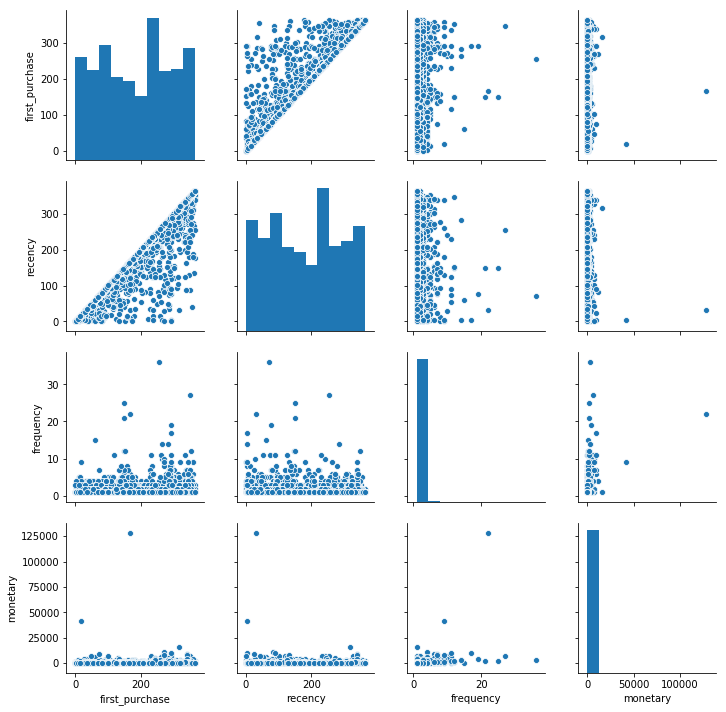

In [13]:
# Plot distributions log scale on y-axis of diagonal historgrams
sns.pairplot(rfm); # diag_kws=dict(log=True)

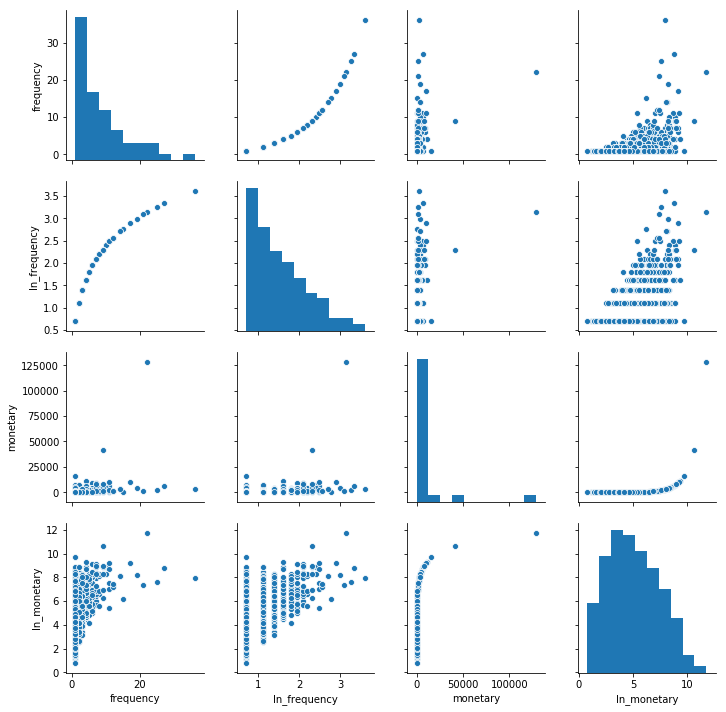

In [14]:
# Apply log transformation to exponential and chi-squared distributions
rfm[['ln_frequency', 'ln_monetary']] = np.log1p(rfm[['frequency', 'monetary']])
sns.pairplot(rfm[['frequency', 'ln_frequency', 'monetary', 'ln_monetary']],
             diag_kws=dict(log=True));

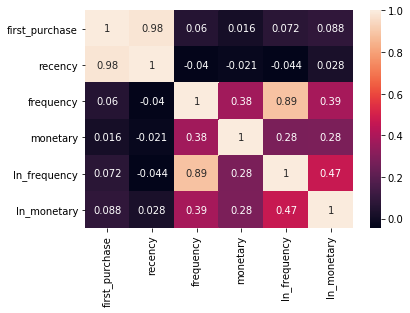

In [15]:
# Investigate multicolinearity
sns.heatmap(rfm.corr(), annot=True);

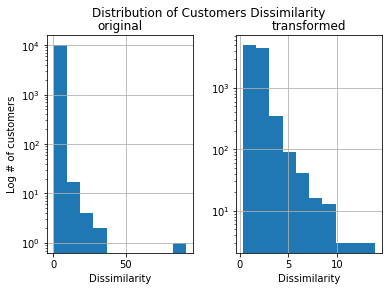

,first_purchase,recency,frequency,monetary,original,transformed
client_id,,,,,,
7813149961404844386,256,70,36,2797.51,36.011518,13.954083
1957458976293878100,167,31,22,128446.52,91.679502,13.211847
6760732402251466726,349,255,27,6530.48,27.062309,12.959665
5526675926038480325,149,149,25,2058.09,24.618989,12.223172
4983264713224875783,149,149,21,1616.33,20.476989,11.404361
2402527199731150932,292,77,19,3761.81,18.601243,11.268555
4984366501121503466,292,4,17,9658.40,17.698611,11.193804
0608915197735218105,264,3,14,3313.23,13.514744,10.027312
9662800125044386280,283,283,14,3239.04,13.452090,9.946689


,original,transformed
count,9962.000000,9962.000000
mean,1.416254,1.758437
std,1.412241,0.952886
min,0.216127,0.311453
25%,0.769895,1.140891
50%,1.321784,1.682267
75%,1.932599,2.216753
max,91.679502,13.954083


In [16]:
# Investigate oultiers based on multivariate dissimilarity
# --------------------------------------------------------

# Create original and transformed variable sets
idxs = {'original': pd.Index(['first_purchase', 'recency', 
                              'frequency', 'monetary']),
        'transformed': pd.Index(['first_purchase', 'recency', 
                                 'ln_frequency', 'ln_monetary'])}

# Calculate dissimilarity for both sets
dissimilarity = pd.DataFrame()
for idx_name, idx in idxs.items():
    dissimilarity[idx_name] = helper.get_dissimilarity(rfm[idx])

# Print distributions of dissimilarities
axes = dissimilarity.hist(log=True)
plt.suptitle('Distribution of Customers Dissimilarity')
for ax in axes[0]:
    ax.set_xlabel('Dissimilarity')
axes[0, 0].set_ylabel('Log # of customers')
plt.show()

# Display overview
ext_summary = (pd.concat([rfm[idxs['original']], dissimilarity], 
                             axis=1)
                 .sort_values('transformed', ascending=False))
display(ext_summary[:10])
display(dissimilarity.describe())

In [17]:
# Monetary value of outliers
display((ext_summary['monetary'][1].sum() / rfm['monetary'].sum()).round(3))

0.072

### 3.1 Data Preparation Discussion
There are 12028 transactions, 9962 customers and no missing values in dataset. 

It seems that google merchendise store:
- is slightly growing new customers from serious drop-out of 200 days ago (present means 1st Aug 2017)
- was doing extremely well in number of customers purchasing goods 220-240 days ago
- but is not doing well keeping customers as >75% of them purchased only ones

#### 3.1.1 Multicollinearity
`first_purhase` and `recency` are higly collinear which inflates importance of time dimension over frequency and monetary value and can negatively effects forming of clusters. I decided to exclude `first_purchase` from analysis.

#### 3.1.2 Distributions
`first_purchase` and `recency` are uniformly or multimodal distributed.`frequency` approximate expenential and `monetary` chi-square distribution. As these are highly skewed distributions both of variables are transformed using natural logarithm: $x_{tr} = ln(x+1)$. Transformation will reduce number of outliers and enable clustering algorithm to form more homogenous clusters with more equal sizes.

#### 3.1.3 Outliers
Multivariate dissimilarity has been used to identify outlier customers from average customer. While raw data shows 1 outlier with huge customer monetary value of 128K$. Even if this is outlier it need to be kept in dataset as it represents 7.2% of total revenue.

Using transformation shows no outliers but 8 underpresented customers in the population, which need to be kept in dataset.

## 4. Modeling
As there is no conceptual knowledge of number of the buyer personas, I will hold to practical consideration of having 3-7 clusters, suppose that distict marketing strategy will be developed for each of the buyer persona. First hierarchical clustering will be used in order to examine all possible cluster solutions. The candidate solutions will be selected for non-hierachical algorithm to form more compact clusters. Then final solution from candidates will be selected in respect to practical consideration.

### 4.1 Research design of the cluster analysis

#### 4.1.1 Define similarity measure
Given that all tree clustering variable are metric the __Euclidean Distance__ is chosen as the similarity measure. If `first_purchase` would need to be included from business point of view, than __Mahalanobis Distance__ could be used to deal with multicolinearity issue.

#### 4.1.2  Sample size
As customer sample is quite big (9962 customers) we can split sample by half to cross-validate cluster solution. Random split can be used with conditions that underepresented customers will remain in both samples to keep data structure. 

#### 4.1.3  Standardization
As the averages and standard deviations of the variables vary a lot, they need to be standardized before entering to cluster algorithm in order to ensure assigning equal weights to each variable when forming clusters.

### 4.2 Assumptions in cluster analysis
#### 4.2.1 Sample representativeness
Considering objective of identifying buyer personas, whole customer population (population = all customer transactions during existance of Google Merchendise Shop) or random sample from that population should be taken. Unfortunately this was not done as available sample is related to fixed time period from 1 Aug 2016 to 1 Aug 2017. For the purpose of this excercise I will limit populaton to this time period. When population is randomly split to half, both of samples can be considered representative.

#### 4.2.2 Multicollinearity
Multicollinearity effects are minimized trough the variable selection process, where `first_purchase` variable was excluded from dataset.

### 4.3 Selecting clustering algorithm
- __Aglomerative Clustering__ will be used in the first step, due to its ability to generate all clustering solutions, time efficiency to handle big samples. The __ward__ method will be used based on __Squared Eclidian Distance__ with advantage of forming homogenous clusters with relatively equal in size. This is especially efficient to used dataset where clustering variable distributions are hihgly skewed with outliers.
- __K-Nearest Neighbour__ non-hierarchical algorithm will be used, due to its ability to handle large samples especialy __MiniBatch__ version  in second step to form more compact clusters

### 4.3.1 Hierarchical Clustering

In [18]:
# Randomly split data into two sets, and keep outliers in each set
# -----------------------------------------------------------------

# Make results deterministic
random_state=1

# Select variables
X = rfm.drop(columns=['first_purchase'])
for idx_name, idx in idxs.items():
    idxs[idx_name] = idx.drop('first_purchase', errors='ignore')

# Split datasets
threshold = 10
X_names = ['train', 'test']
size = 0.5
Xs = helper.split_data(X, idxs['transformed'], X_names, threshold, 
                       test_size=size, random_state=random_state)

for X_name, X in Xs.items():
    print('Dataset', X_name, 'of shape', X.shape)

Dataset train of shape (4984, 5)
Dataset test of shape (4984, 5)


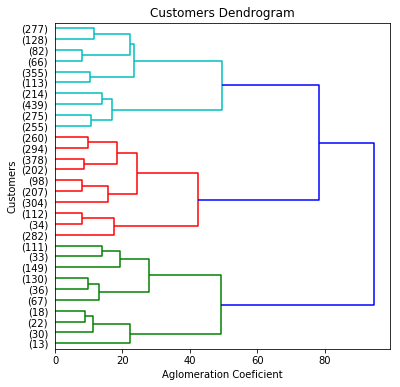

In [19]:
# BUILD AND OPTIMIZE MODEL FOR 1st DATASET
# ----------------------------------------

# Standardize datasets
scalers={}
Xs_std = {}
idxs['all_inputs'] = pd.Index([
    'recency', 'frequency', 'monetary', 'ln_frequency', 'ln_monetary', 
    'recency_std', 'frequency_std', 'monetary_std','ln_frequency_std', 
    'ln_monetary_std'
])

for X_name, X in Xs.items():
    scalers[X_name] = StandardScaler().fit(X)
    Xs_std[X_name] = scalers['train'].transform(X)
    Xs_std[X_name] = pd.DataFrame(Xs_std[X_name], 
                                  columns=Xs[X_name].columns+'_std', 
                                  index=Xs[X_name].index)
    Xs[X_name] = (pd.concat([Xs[X_name], Xs_std[X_name]], axis=1)
                  .reindex(idxs['all_inputs'], axis=1))

# Agglomerative Clustering with average linkage
idxs['transformed_std'] = pd.Index(
    ['recency_std', 'ln_frequency_std', 'ln_monetary_std'])

agl_cluster = linkage(Xs_std['train'][idxs['transformed_std']], 'ward')

# Construct dendrogram
plt.figure(figsize=(6, 6))
dn = dendrogram(agl_cluster, p=30, truncate_mode='lastp', orientation='right')
plt.title('Customers Dendrogram')
plt.xlabel('Aglomeration Coeficient')
plt.ylabel('Customers')
plt.show()

In [20]:
# Step 1: Inspect outliers in agglomeration schedule if any
pass

# Step 2: Consider removing outliers if appropriate
pass

# Step 3: Run algomerative clustering again go to step 1
pass

# Note: no outliers

In [21]:
# Determine number of candidate solutions
# ---------------------------------------

# Get aglomeration shedule
agl_schedule = pd.DataFrame(
    agl_cluster,
    columns=['cluster1', 'cluster2', 'coefficient', 'cluster_size'],
    index=pd.Index(range(1, Xs_std['train'].shape[0]), name='stage')
)

# Calculate proportional heterogeneity increase
agl_schedule['num_of_clusters'] = list(reversed(agl_schedule.index))
agl_schedule['prop_heterogeneity_increase'] = (
    agl_schedule['coefficient']
    .diff()
    .shift(periods=-1)
    / agl_schedule['coefficient']
)

# Print last x stages of algomeration schedule
stages = 15
display(agl_schedule[-stages:])

,cluster1,cluster2,coefficient,cluster_size,num_of_clusters,prop_heterogeneity_increase
stage,,,,,,
4969,9918.0,9938.0,15.791009,609.0,15,0.069112
4970,9946.0,9951.0,16.882356,1183.0,14,0.032872
4971,9923.0,9940.0,17.437321,428.0,13,0.053955
4972,9941.0,9943.0,18.378145,1134.0,12,0.042347
4973,9934.0,9950.0,19.156413,293.0,11,0.154451
4974,9930.0,9947.0,22.115149,83.0,10,0.010029
4975,9939.0,9948.0,22.336937,553.0,9,0.043163
4976,9945.0,9958.0,23.301075,1021.0,8,0.047418
4977,9952.0,9955.0,24.405973,1743.0,7,0.141862


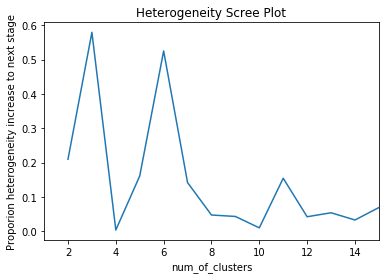

In [22]:
# Print heterogenity scree plot
(agl_schedule
 .set_index('num_of_clusters')
 ['prop_heterogeneity_increase'][-stages:]
 .plot(title='Heterogeneity Scree Plot'))
plt.ylabel('Proporion heterogeneity increase to next stage');

In [23]:
# Selected candidate solutions
num_seeds = [3, 6]

# Profile candiate solutions
# --------------------------

for k in num_seeds:
    
    # Fenerate candidate solution labels
    labels = fcluster(agl_cluster, k, criterion='maxclust')
    Xs['train']['hierarchic_clusters_{}'.format(k)] = labels
    
    # Display cluster sizes
    display(Xs['train'].groupby('hierarchic_clusters_{}'.format(k))
                       .size()
                       .rename('cluster_sizes'))

display(Xs['train'].head())

hierarchic_clusters_3
1     609
2    2171
3    2204
Name: cluster_sizes, dtype: int64

hierarchic_clusters_6
1      83
2     526
3     428
4    1743
5    1183
6    1021
Name: cluster_sizes, dtype: int64

,recency,frequency,monetary,ln_frequency,ln_monetary,recency_std,frequency_std,monetary_std,ln_frequency_std,ln_monetary_std,hierarchic_clusters_3,hierarchic_clusters_6
client_id,,,,,,,,,,,,
7133939846118520732,257,1,25.99,0.693147,3.295466,0.721933,-0.203508,-0.087949,-0.311743,-0.822272,2,4
6269547197366207744,349,1,164.43,0.693147,5.108548,1.577045,-0.203508,-0.017668,-0.311743,0.783385,2,3
1644471510299169992,200,1,19.99,0.693147,3.044046,0.192136,-0.203508,-0.090995,-0.311743,-1.044929,2,4
4863941202505455588,56,5,2458.15,1.791759,7.807571,-1.146300,3.146721,1.146773,4.424456,3.173627,1,1
2339818672404404924,228,1,173.57,0.693147,5.162326,0.452387,-0.203508,-0.013028,-0.311743,0.831010,3,6


PROFILE SUMMARY FOR HIERARCHIC_CLUSTERS_3
-----------------------------------------

Hypothesis testing of clusters averages difference
--------------------------------------------------


mean             median             anova_p levene_p  \
hierarchic_clusters_3     1     2     3      1     2     3                    
recency_std           -0.11  0.85 -0.81  -0.16  0.84 -0.86     0.0      0.0   
ln_frequency_std       2.24 -0.31 -0.31   1.44 -0.31 -0.31     0.0      0.0   
ln_monetary_std        1.20 -0.26 -0.08   1.04 -0.37 -0.17     0.0      0.0   

                      shapiro_wilk_p kruskal_wallis_p  
hierarchic_clusters_3                                  
recency_std                      0.0              0.0  
ln_frequency_std                 0.0              0.0  
ln_monetary_std                  0.0              0.0


Post-hoc test: posthoc_nemenyi
-------------------------------


clustering variable: recency_std


,1,2,3
1,-1,0,0
2,0,-1,0
3,0,0,-1



clustering variable: ln_frequency_std


,1,2,3
1,-1,0,0
2,0,-1,1
3,0,1,-1



clustering variable: ln_monetary_std


,1,2,3
1,-1,0,0
2,0,-1,0
3,0,0,-1



Profile vizualization
----------------------


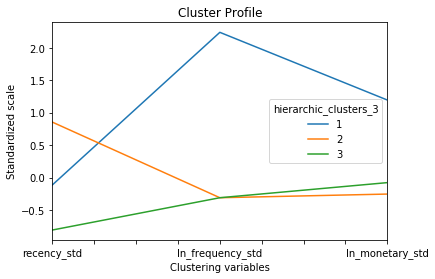


Clusters vizualization
-----------------------


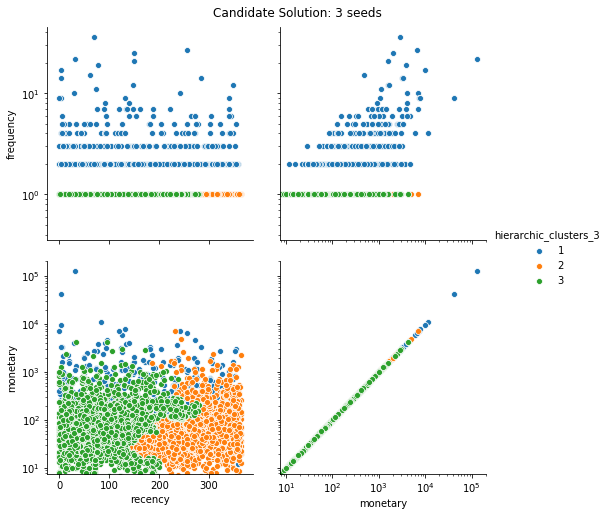

Profile characteristics
-----------------------


mean                     median                 
                      frequency monetary recency frequency monetary recency
hierarchic_clusters_3                                                      
1                           3.0    867.1   167.2         2    220.0     162
2                           1.0     94.8   271.2         1     44.0     270
3                           1.0    117.5    92.2         1     55.3      87



PROFILE SUMMARY FOR HIERARCHIC_CLUSTERS_6
-----------------------------------------

Hypothesis testing of clusters averages difference
--------------------------------------------------


mean                               median              \
hierarchic_clusters_6     1     2     3     4     5     6      1     2     3   
recency_std           -0.07 -0.12  1.30  0.74 -1.00 -0.59  -0.24 -0.14  1.37   
ln_frequency_std       5.43  1.74 -0.31 -0.31 -0.31 -0.31   5.09  1.44 -0.31   
ln_monetary_std        2.77  0.95  0.97 -0.56 -0.75  0.69   2.61  0.84  0.79   

                                        anova_p levene_p shapiro_wilk_p  \
hierarchic_clusters_6     4     5     6                                   
recency_std            0.68 -1.01 -0.65     0.0      0.0            0.0   
ln_frequency_std      -0.31 -0.31 -0.31     0.0      0.0            0.0   
ln_monetary_std       -0.54 -0.67  0.52     0.0      0.0            0.0   

                      kruskal_wallis_p  
hierarchic_clusters_6                   
recency_std                        0.0  
ln_frequency_std                   0.0  
ln_monetary_std                    0.0


Post-hoc test: posthoc_nemenyi
-------------------------------


clustering variable: recency_std


,1,2,3,4,5,6
1,-1,1,0,0,0,0
2,1,-1,0,0,0,0
3,0,0,-1,0,0,0
4,0,0,0,-1,0,0
5,0,0,0,0,-1,0
6,0,0,0,0,0,-1



clustering variable: ln_frequency_std


,1,2,3,4,5,6
1,-1,0.08,0,0,0,0
2,0.08,-1,0,0,0,0
3,0,0,-1,1,1,1
4,0,0,1,-1,1,1
5,0,0,1,1,-1,1
6,0,0,1,1,1,-1



clustering variable: ln_monetary_std


,1,2,3,4,5,6
1,-1,0,0,0,0,0
2,0,-1,0.72,0,0,0.77
3,0,0.72,-1,0,0,0.04
4,0,0,0,-1,0,0
5,0,0,0,0,-1,0
6,0,0.77,0.04,0,0,-1



Profile vizualization
----------------------


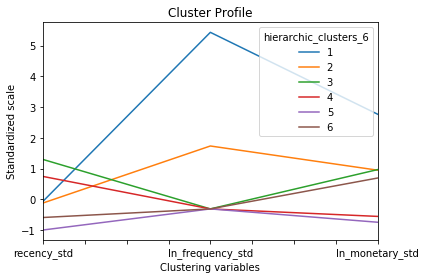


Clusters vizualization
-----------------------


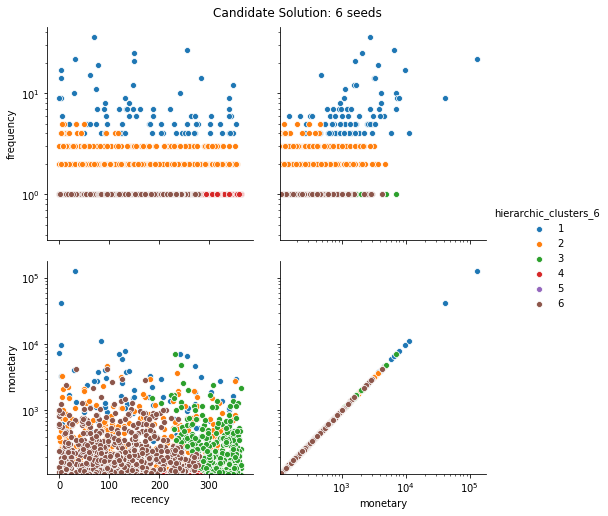

Profile characteristics
-----------------------


mean                     median                 
                      frequency monetary recency frequency monetary recency
hierarchic_clusters_6                                                      
1                           7.7   4162.3   172.2         6   1300.9     153
2                           2.3    347.2   166.4         2    176.2     164
3                           1.0    314.6   319.0         1    166.4     327
4                           1.0     40.9   259.5         1     36.0     252
5                           1.0     32.0    71.9         1     30.9      71
6                           1.0    216.6   115.7         1    122.2     109

In [24]:
# Test candidate solutions
# ---------------------------

# Initiate profile function arguments
idxs['hierarchic_clusters'] = Xs['train'].columns[
    Xs['train'].columns.str.contains('hierarchic_clusters')]

post_hoc_test = sp.posthoc_nemenyi

# Execute cluster profile tests, print cluster profiles & scatterplots
for solution in idxs['hierarchic_clusters']:
    summary, post_hoc, prof_ax, clst_pg = (
        helper.analyze_cluster_solution(
            Xs['train'], idxs['transformed_std'], 
            solution, post_hoc_fnc=post_hoc_test
        )
    )
    
    # Print original variable means and averages per cluster
    str_ = 'Profile characteristics'
    print(str_ + '\n' + '-' * len(str_))

    display(Xs['train']
            .groupby(solution)
            [idxs['original']]
            .agg(['mean', 'median'])
            .round(1)
            .swaplevel(axis=1)
            .sort_index(level=0, axis=1))
    
    print('\n')

In [25]:
# Revenue overview of 6 cluster solution
monetary_cls_6 = (Xs['train']
                  .groupby('hierarchic_clusters_6', as_index=False)
                  ['monetary']
                  .sum())
monetary_cls_6['prop_monetary'] = (monetary_cls_6['monetary'] 
                                   / Xs['train']['monetary'].sum())
display(monetary_cls_6)

,hierarchic_clusters_6,monetary,prop_monetary
0,1,345467.88,0.347912
1,2,182615.29,0.183907
2,3,134661.19,0.135614
3,4,71226.16,0.071730
4,5,37825.60,0.038093
5,6,221178.24,0.222743


#### 4.3.1.1 Hierarchical Clustering Discussion
##### 4.3.1.1.1 Initial Cluster Results
Dendrogram and aglomeration schedule helps to understnand the clustering process. 

Dendogram shows that indeed natural logarithm tranformation of `recency` and `monetary` and __ward method__ have helped to form relatively equal clusters with no outliers. When inspecting solution with 30 clusters the cluster size ranges from 13 to 439customers. There are no clusters with single customer which shows alorithm robustness towards outliers.

Ex. if __Average Linkage__ method would be used there would be tree clusters [4977, 4983, 4980] with one customer in later algomeration stages. It would be necessary to remove those and re-run the algorithm again to reach similar cluster homogenity and sizes as in __Ward Method__ case.

_Note:_ To try __Average Linkage__ method just change `ward` to `average` in cell In [18]

##### 4.3.1.1.2 Determining Preliminary Cluster Solutions
Candidate cluster solutions will be specified using __Stopping Rule__. It is based on assesing the changes in heterogeity between cluster solutions. The basic rational is that when large change in heterogeneity occur in moving form one stage to the next, the prior cluster solutions should be selected because the next stage is joining quite diffrent clusters. The proportion heterogeneity change to next stage is calculated as: 

$prop\_heterogeneity\_increase_{\text{i}} = \cfrac{coefficient_{\text{i+1}} - coefficient_{\text{i}}}{coefficient_{\text{i}}}$

__Heterogeneity Scree Plot__ shows that proprotionaly highest heterogeneity increase is when going from 3 to 2 and 6 to 5 clusters solutions. Therefore two solution candidates with 3 and 6 clusters were further selected for profiling.

##### 4.3.1.1.3 Profiling of Cluster Solutions
Before proceeding to nonhierarchical analysis, the profiling of selected cluster solutions is done to confirm that the differences between customer clusters are distincitive and sifnificant in recency and frequency of purchase and revenue (clustering variables)

Using __one-way ANOVA__ to identify clustering variable is not practical in this case as ANOVA prerequisites of __residuals normality__ (Shapiro-Wilk Test) and __group variance homogeneity__ (Leven's test) are not met. Instead non parametric __Kruskal-Wallis test__ was used to evaluate overal sifnificance and __Post-hoc Nemenyi__ was used to evaluate pair-wise significance.

The results shows that there are significant diffrences between the clusters on all tree variables in both solutions. These provide initial evidence that each of the tree and six clusters is distinctive.

Examination of means of cluster variables shows:
 - tree clusters solution
   - cluster 1 (609 customers) has highest mean on frequency 3.9 and monetary value 867USD representing ___"frequent shopers and high spenders"___
   - cluster 2 (2171 customers) with highest recency 271 days, low frequency 1, most probably representing ___"customer churn"___
   - cluster 3 (2204 customers) with lowest recency 94 days, low frequency 1, represening ___"new customers"___ 
   
 - six clusters solution
   - cluster 1 (83 customers) has highest mean on frequency 7.7 and monetary value 4162USD representing ___"frequent shoppers and huge spenders"___ most probably business customers
   - cluster 2 (526 customers) has second highest mean on frequency 2.3 (no significant diffrence with cluster 1 frequency mean 7.7) and second highest monetary value 347USD representing ___"frequent shoppers and moderate spenders"___
   - cluster 3 (428 customers) has highest recency 319 days, lowest frequency 1 and moderate monetary value 315USD representing ___"moderate spenders churn"___
   - cluster 4 (1743 customers) with 2nd highest recency 259 days, lowest frequency 1 and low monetary value 41USD represening ___"low spenders churn"___
   - cluster 5 (1183 customers) low monetary value 32USD, recency 71 days and frequency 1 representing ___"new low spenders"___
   - cluster 6 (1021 customers) low frequency 1 and moderate monetary value 216USD representing ___"one time moderate spenders"___
   
Both of the solutions will be considered in non-hierarchical analysis due to
 - simplicity and marketing cost efficiency of tree custers solution, where only 3 strategies need to be developed
 - ability to specify buyer personas with higher granularity, where cluster 1 typology is in center of interest representing only 83 customers who generated 35% (345K USD) of revenue.

### 4.3.2 Nonhierarchical Clustering
Nonhierarchical clustering methods have the advantage of being able to better "optimize" cluster solutions by reassigning observations until maximum homogeneity (similarity) is achieved. This second step in clustering process uses number of clusters (seeds) determined in hierarchical clustering. The clustering solutions are then compared to
- how do they generalized on population
- their predictability in respect to additional taxonomy variables (not included in this example)
- aplicability to business objective (forming marketing strategies for different buyers personas and best ROI)

#### 4.3.2.1 Seed Points Generation
Tree and six seeds will be used respectively. No random method neither custom selection of centroids will be used. There are no priori business information about rfm characteristic of buyer personas and random method suffers from local optima issue. To cope with this sklearn __K-means++__ initialization method will be used to initialize centroids to be distant from each other, leading to provably better results than random initiallization as shown in the [reference](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf).

#### 4.3.2.2 Clustering Algorithm
__Optimization algorithm__ will be used. It allows reasignment of observation among clusters until a minimum level of heterogeneity is reached. Sklearn `KMeans` object's parameter `algorithm='auto'` will determine which algorithm branch to use according data structure. `full` for sparce data and `elkan` for dense data. 

In [26]:
# K-mean clustering for selected candidate solutions
kmeans, labels = {}, {}
for k in num_seeds:
    
    # Fit model
    kmeans['non_sorted_{}'.format(k)] = (
        KMeans(n_clusters=k, 
               random_state=random_state, 
               init='k-means++')
        .fit(Xs['train'][idxs['transformed_std']])
    )
    
    # Predict lables
    labels['non_sorted_{}'.format(k)] = (
        kmeans['non_sorted_{}'.format(k)]
        .predict(Xs['train'][idxs['transformed_std']])
    )
    
    Xs['train']['nonhierarchic_clusters_{}'.format(k)] = (
        labels['non_sorted_{}'.format(k)]+1
    )
    
# Display cluster sizes
idxs['nonhierarchic_clusters'] = Xs['train'].columns[
    Xs['train'].columns.str.contains('nonhierarchic_clusters')]

for solution in idxs['nonhierarchic_clusters']:
    display(Xs['train'].groupby(solution)
                      .size()
                      .rename('cluster_sizes')) 

nonhierarchic_clusters_3
1     497
2    2298
3    2189
Name: cluster_sizes, dtype: int64

nonhierarchic_clusters_6
1    1490
2     794
3     494
4     645
5      83
6    1478
Name: cluster_sizes, dtype: int64

PROFILE SUMMARY FOR NONHIERARCHIC_CLUSTERS_3
--------------------------------------------

Hypothesis testing of clusters averages difference
--------------------------------------------------


mean             median             anova_p  \
nonhierarchic_clusters_3     1     2     3      1     2     3           
recency_std              -0.14  0.87 -0.88  -0.23  0.83 -0.90     0.0   
ln_frequency_std          2.37 -0.26 -0.26   1.44 -0.31 -0.31     0.0   
ln_monetary_std           1.57 -0.11 -0.24   1.37 -0.21 -0.37     0.0   

                         levene_p shapiro_wilk_p kruskal_wallis_p  
nonhierarchic_clusters_3                                           
recency_std                   0.0            0.0              0.0  
ln_frequency_std              0.0            0.0              0.0  
ln_monetary_std               0.0            0.0              0.0


Post-hoc test: posthoc_nemenyi
-------------------------------


clustering variable: recency_std


,1,2,3
1,-1,0,0
2,0,-1,0
3,0,0,-1



clustering variable: ln_frequency_std


,1,2,3
1,-1,0,0
2,0,-1,1
3,0,1,-1



clustering variable: ln_monetary_std


,1,2,3
1,-1,0,0
2,0,-1,0
3,0,0,-1



Profile vizualization
----------------------


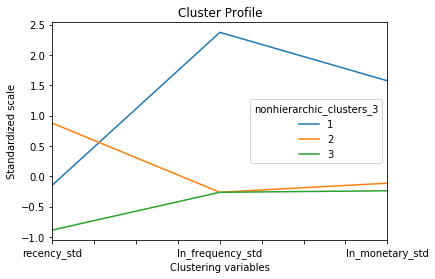


Clusters vizualization
-----------------------


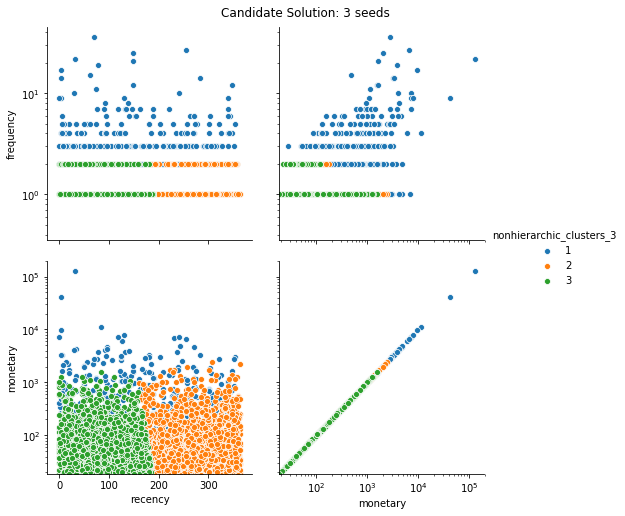

Profile characteristics
-----------------------


mean                     median                 
                         frequency monetary recency frequency monetary recency
nonhierarchic_clusters_3                                                      
1                              3.2   1129.4   163.8         2    320.9     155
2                              1.0    105.3   273.3         1     52.7     269
3                              1.0     86.7    84.2         1     44.2      83



PROFILE SUMMARY FOR NONHIERARCHIC_CLUSTERS_6
--------------------------------------------

Hypothesis testing of clusters averages difference
--------------------------------------------------


mean                               median        \
nonhierarchic_clusters_6     1     2     3     4     5     6      1     2   
recency_std              -0.95  1.07 -0.12 -0.72 -0.18  0.75  -0.96  1.13   
ln_frequency_std         -0.30 -0.30  1.75 -0.31  5.47 -0.30  -0.31 -0.31   
ln_monetary_std          -0.60  0.67  1.04  0.96  2.75 -0.67  -0.56  0.49   

                                                 anova_p levene_p  \
nonhierarchic_clusters_6     3     4     5     6                    
recency_std              -0.14 -0.72 -0.30  0.66     0.0      0.0   
ln_frequency_std          1.44 -0.31  5.09 -0.31     0.0      0.0   
ln_monetary_std           0.93  0.76  2.61 -0.63     0.0      0.0   

                         shapiro_wilk_p kruskal_wallis_p  
nonhierarchic_clusters_6                                  
recency_std                         0.0              0.0  
ln_frequency_std                    0.0              0.0  
ln_monetary_std                     0.0              0.0


Post-hoc test: posthoc_nemenyi
-------------------------------


clustering variable: recency_std


,1,2,3,4,5,6
1,-1,0,0,0,0,0
2,0,-1,0,0,0,0
3,0,0,-1,0,1,0
4,0,0,0,-1,0,0
5,0,0,1,0,-1,0
6,0,0,0,0,0,-1



clustering variable: ln_frequency_std


,1,2,3,4,5,6
1,-1,1,0,1,0,1
2,1,-1,0,1,0,1
3,0,0,-1,0,0.09,0
4,1,1,0,-1,0,1
5,0,0,0.09,0,-1,0
6,1,1,0,1,0,-1



clustering variable: ln_monetary_std


,1,2,3,4,5,6
1,-1,0,0,0,0,0.16
2,0,-1,0.05,0.01,0,0
3,0,0.05,-1,1,0,0
4,0,0.01,1,-1,0,0
5,0,0,0,0,-1,0
6,0.16,0,0,0,0,-1



Profile vizualization
----------------------


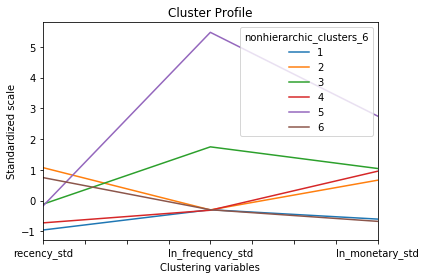


Clusters vizualization
-----------------------


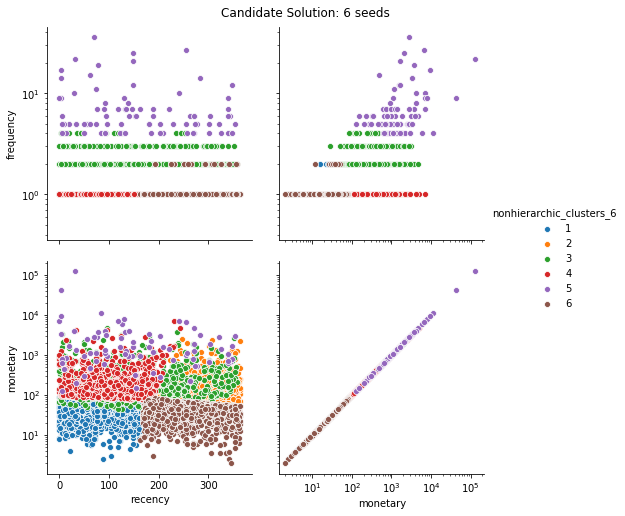

Profile characteristics
-----------------------


mean                     median                 
                         frequency monetary recency frequency monetary recency
nonhierarchic_clusters_6                                                      
1                              1.0     38.6    76.6         1     35.1    76.0
2                              1.0    197.9   294.8         1    118.4   300.5
3                              2.3    368.0   166.9         2    194.0   164.5
4                              1.0    310.3   101.6         1    159.4   102.0
5                              7.7   4156.0   160.5         6   1300.9   147.0
6                              1.0     34.8   260.0         1     32.4   250.0

In [27]:
# Test candidate solutions
# ---------------------------

# Execute cluster profile tests, print cluster profiles & scatterplots
for solution in idxs['nonhierarchic_clusters']:
    summary, post_hoc, prof_ax, clst_pg = (
        helper.analyze_cluster_solution(
            Xs['train'], idxs['transformed_std'], 
            solution, post_hoc_fnc=post_hoc_test
        )
    )
    
    # Print original variable means and averages per cluster
    str_ = 'Profile characteristics'
    print(str_ + '\n' + '-' * len(str_))

    display(Xs['train']
            .groupby(solution)
            [idxs['original']]
            .agg(['mean', 'median'])
            .round(1)
            .swaplevel(axis=1)
            .sort_index(level=0, axis=1))
    
    print('\n')

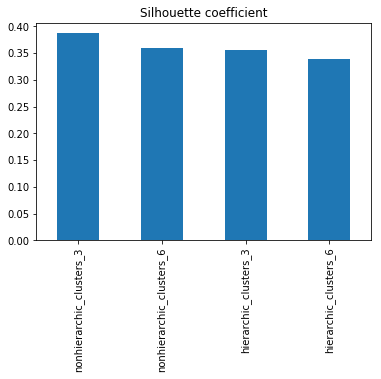

nonhierarchic_clusters_3    0.387130
nonhierarchic_clusters_6    0.359633
hierarchic_clusters_3       0.354846
hierarchic_clusters_6       0.339845
Name: silhouette_score, dtype: float64

In [28]:
# Evaluate within clusters homogeneity and 
# between clusters heterogeneity using Silhouette coeficient
idxs['clusters'] = Xs['train'].columns[
    Xs['train'].columns.str.contains('clusters')]

score = pd.Series(index=idxs['clusters'], name='silhouette_score')

for k, solution in zip(num_seeds * 2, idxs['clusters']):
    score[solution] = silhouette_score(Xs['train'][idxs['transformed_std']],
                                       Xs['train'][solution], 
                                       random_state=random_state)
# Diplay overview
score = score.sort_values(ascending=False)
score.plot.bar(title = 'Silhouette coefficient')
plt.show()
display(score)

##### 4.3.2.1 Discussion on Nonhierarchical Clustering
Hierarchical and nonhierarchical solutions are very similary when looking to profile vizualization. The nonhierarchical solutions have ability to form more homogenous clusters with higher distictivness between clusters as it can be seen comparing clusters vizualization. This is due to the ability to reassign observations between clusters. The both 3 and 6 nonhierarchical clusters solutions have higher __Silhouette Score__ compared to their hierarchical versions.

##### 4.3.2.1.1 Profiling of Cluster Solutions
The results are very similar to hierarchical solution. They shows that there are significant diffrences between the clusters on all tree variables in both solutions. These provide initial evidence that each of the tree and six clusters is distinctive.

Examination of means of cluster variables shows sligth changes in profiles:
 - tree clusters solution
   - cluster 1 (497 customers) has highest mean on frequency 3.2 and monetary value 1129USD representing ___"frequent shopers and high spenders"___
   - cluster 2 (2298 customers) with highest recency 273 days, low frequency 1, most probably representing ___"customer churn"___
   - cluster 3 (2189 customers) with lowest recency 87 days, low frequency 1, represening ___"new customers"___ 
   
 - six clusters solution
   - cluster 5 (83 customers) has highest mean on frequency 7.7 and monetary value 4156USD representing ___"frequent shoppers and huge spenders"___ most probably business customers (matching hierarchical cluster 1)
   - cluster 3 (494 customers) has second highest mean on frequency 2.3 (no significant diffrence with cluster 1 frequency mean 7.7) and second highest monetary value 368USD representing ___"frequent shoppers and moderate spenders"___ (matching hierarchical cluster 2)
   - cluster 2 (794 customers) has highest recency 294days, lowest frequency 1 and moderate monetary value 198USD representing ___"moderate spenders churn"___ (matching hierarchical clusters 3)
   - cluster 6 (1478 customers) with 2nd highest recency 260 days, lowest frequency 1 and low monetary value 35USD represening ___"low spenders churn"___ (matching hierarchical cluster 4)
   - cluster 1 (1490 customers) has low monetary value 39USD, recency 77 days and frequency 1 representing ___"new low spenders"___ (matching hierarchical cluster 5)
   - cluster 4 (1645 customers) has low frequency 1 and moderate monetary value 310USD representing ___"one time moderate spenders"___ (matchin hierarchical cluster 6)

In [29]:
# initiate buyer personas names
cluster_names = {3: ['frequent shoppers and high spenders',
                     'customer churn',
                     'new customers'],
                 6: ['new low spenders',
                     'moderate spenders churn',
                     'frequent shoppers and moderate spenders',
                     'one time moderate spenders',
                     'frequent shoppers and huge spenders',
                     'low spenders churn']}

## 5. Evaluation
The purpose of this section is to assess if generalizability of the solution to population.

### 5.1 Clusters Stability
Factors such as initial seed points, observation ordering can effect cluster membership in nonhierarchical clustering. To check stability of the clusters, dataset is sorted by monetary value and compared with original 3 and 6 cluster solutions.
Solutions are cross tabulated for comparison of missmatched cluster membership where following rules are applied:

| Cluster Stability 	| Missmatch in % 	|
|-------------------	| ----------------	|
| very stable       	|     <0-10>     	|
| stable            	|     (10-20>    	|
| somewhat stable   	|     (20-25>    	|
| not stable        	|       >25      	|

___Note___: Clusters numbers may not correspond to each other across diffrent algorithms and differently sorted datasets. Therefore do not expect highest numbers on diagonal of confusion matrix. Matching of the clusters need to be doublechecked vissually on scatterplots.

In [30]:
# Generate sorted dataset by monetary value
Xs['train_sorted'] = Xs['train'].sort_values('monetary_std').copy()

# K-mean clustering for selected candidate solutions
for k in num_seeds:
    
    # Fit model
    kmeans['sorted_{}'.format(k)] = (
        KMeans(n_clusters=k, 
               random_state=random_state, 
               init='k-means++')
        .fit(Xs['train_sorted'][idxs['transformed_std']])
    )
    
    # Predict lables
    labels['sorted_{}'.format(k)] = (
        kmeans['sorted_{}'.format(k)]
        .predict(Xs['train_sorted'][idxs['transformed_std']])
    )
    
    Xs['train_sorted']['nonhierarchic_sorted_clusters_{}'.format(k)] = (
        labels['sorted_{}'.format(k)] + 1
    )

    # Cross tabulation
    cross_tab, missmatch, total_missmatch = helper.get_missmatch(
        index=Xs['train']['hierarchic_clusters_{}'.format(k)],
        columns=Xs['train_sorted']['nonhierarchic_sorted_clusters_{}'.format(k)],
        rownames=['original'],
        colnames=['sorted']
    )

    print(cross_tab,'\n')
    print(missmatch, '\n')
    print('Total missmatch proportion: {:.2f}\n\n\n'.format(total_missmatch))

sorted       1     2    3
original                 
1           61    65  483
2          175  1992    4
3         1953   241   10 

original
1    0.206897
2    0.082450
3    0.113884
Name: missmatch_proportion, dtype: float64 

Total missmatch proportion: 0.11



sorted      1     2     3    4   5    6
original                               
1           0     0     0    0  79    4
2           5    14    13    0   4  490
3         421     0     0    7   0    0
4         236    91  1415    1   0    0
5           0  1155    28    0   0    0
6         132   230    22  637   0    0 

original
1    0.048193
2    0.068441
3    0.016355
4    0.188181
5    0.023669
6    0.376102
Name: missmatch_proportion, dtype: float64 

Total missmatch proportion: 0.16





### 5.1.1 Clusters Stability Discussion
The 3 and 6 cluster solution are stable as membership missmatched is > 10% (11%, 16% respectively). The 6 cluster solution showed 38% missmatched. There is a possibility to improve stability of 6 cluster solution by selecting custom centerpoints, but this would need to be supported by priori bussiness information.

## 5.2 Clusters Generalizability
Clustering methods belongs to unsupervised machine learning algorithms, so there are no ground true labels to calculate accuracy to check how model generalize to population. The diffrent approach can be used using cross tabulation between two solutions and calculating missmatch where same rules above apply. The following procedure is used: 
 - Data are randomly splitted by half to `train` and `test` sample.
 - The `train` sample is used to train firt clustering model which needs to be evaluated. 
 - "True" labels are estimated by second clustering model trained on `test` sample.  
 - Predicted labels are aquired using `KMeans.predict` function of the first fitted model
 - First model generalizability is evaluated using __confusion matrix__ cross-tabulating "True" and predicted labels

In [31]:
# Validate solution generalizability to whole population
# ------------------------------------------------------
for k in num_seeds:
    
    kmeans['train_{}'.format(k)] = kmeans['non_sorted_{}'.format(k)]
    
    # Fit model on test dataset
    kmeans['test_{}'.format(k)] = (
        KMeans(n_clusters=k, 
               random_state=random_state, 
               init='k-means++')
        .fit(Xs['test'][idxs['transformed_std']])
    )
    
    # Predict lables with model fitted on test dataset
    labels['test_true_{}'.format(k)] = (
        kmeans['test_{}'.format(k)]
        .predict(Xs['test'][idxs['transformed_std']])
    )
    
    Xs['test']['true_clusters_{}'.format(k)] = (
        labels['test_true_{}'.format(k)] + 1
    )

    # Predict lables with model fitted on train dataset
    labels['test_predicted_{}'.format(k)] = (
        kmeans['train_{}'.format(k)]
        .predict(Xs['test'][idxs['transformed_std']])
    )
    
    Xs['test']['predicted_clusters_{}'.format(k)] = (
        labels['test_predicted_{}'.format(k)] + 1
    )
    
    # Cross tabulation
    cross_tab, missmatch, total_missmatch = helper.get_missmatch(
        index=Xs['test']['true_clusters_{}'.format(k)],
        columns=Xs['test']['predicted_clusters_{}'.format(k)],
        rownames=['true'],
        colnames=['predicted']
    )

    print(cross_tab,'\n')
    print(missmatch, '\n')
    print('Total missmatch proportion: {:.2f}\n\n\n'.format(total_missmatch))

predicted    1     2     3
true                      
1            0  2307    14
2            0     1  2168
3          440    30    24 

true
1    0.006032
2    0.000461
3    0.109312
Name: missmatch_proportion, dtype: float64 

Total missmatch proportion: 0.01



predicted     1    2    3    4   5     6
true                                    
1             0   71    0    0   0  1427
2             0    5  475    0   4     0
3          1337    0    0    0   0    29
4             0    0    0    0  46     0
5             0  764    0   39   0     9
6           164    0    0  612   0     2 

true
1    0.047397
2    0.018595
3    0.021230
4    0.000000
5    0.059113
6    0.213368
Name: missmatch_proportion, dtype: float64 

Total missmatch proportion: 0.06





### 5.2.1 Discussion on Clusters Generalizability
The 3 cluster solution generalize very well to population with 1% clusters membership missmatch (Accuracy Error). The 6 cluster solution generalize well with 6% error. It is acceptable to profile and compare both solutions on additional non clustering variables.

In [32]:
# Predict cluster labels for whole dataset
# ----------------------------------------

# Standardize data
X = rfm.drop(columns=['first_purchase'])
X_std = scalers['train'].transform(X)
X_std = pd.DataFrame(X_std, 
                     columns=X.columns+'_std', 
                     index=X.index)
X = (pd.concat([X, X_std], axis=1)
              .reindex(idxs['all_inputs'], axis=1))

# Predict labels
labels = {}
for k in num_seeds:
    labels[k] = (kmeans['train_{}'.format(k)]
                 .predict(X[idxs['transformed_std']]))
    
    X['clusters_{}'.format(k)] = labels[k] + 1

y_pred = X[X.columns[X.columns.str.contains('clusters')]]
display(y_pred)

,clusters_3,clusters_6
client_id,,
0000213131142648941,3,1
0002871498069867123,2,2
0003450834640354121,2,6
0003961110741104601,3,1
000435324061339869,2,6
...,...,...
9991633376050115277,3,1
9994767073213036303,2,2
9997409246962677759,2,6


## 5.3 Profiling Cluster Solution on Additional Variables
The profiling stage involves discribing the charateristics of the each buyer persona (cluster) to explain how it may differ in relevant dimensions as demograpics, consumption patterns and behaviors. These are the variables not included in cluster analysis. This section provides answer on second quastion: What are the unique characteristics of buyer personas?

### 5.3.1 Data Understading

In [48]:
%%time
# Query additional variables from google analytics dataset
query = '''
SELECT
    CONCAT(fullVisitorId, CAST(visitId AS STRING)) AS session_id,
    visitNumber AS visit_number,
    date,
    totals.pageviews AS pageviews,
    totals.timeOnSite AS time_on_site,
    trafficSource.referralPath AS referral_path,
    trafficSource.campaign AS campaign,
    trafficSource.source AS source,
    trafficSource.medium AS medium,
    trafficSource.keyword AS traffic_keyword,
    trafficSource.adContent AS ad_content,
    trafficSource.adwordsClickInfo.page AS ad_page,
    trafficSource.adwordsClickInfo.slot AS ad_slot,
    trafficSource.adwordsClickInfo.adNetworkType AS ad_network_type,
    trafficSource.isTrueDirect AS direct_traffic,
    device.browser AS browser,
    device.operatingSystem AS operating_system,
    device.deviceCategory AS device_category,
    geoNetwork.continent AS continent,
    geoNetwork.subContinent AS subcontinent,
    geoNetwork.country AS country,
    geoNetwork.region AS region,
    geoNetwork.metro AS metro,
    geoNetwork.city AS city,
    geoNetwork.networkDomain AS domain,
    customDimensions.value AS sales_region,
    hits.hour AS hour,
    hits.transaction.transactionId AS transaction_id,
    hits_product.productSKU AS product_sku,
    hits_product.v2ProductName AS product_name,
    hits_product.v2ProductCategory AS product_category,
    hits_product.productBrand AS product_brand,
    (hits_product.productPrice / 1e6) AS product_price,
    hits_product.productQuantity AS product_quantity,
    hits.social.hasSocialSourceReferral AS is_social_referral,
    hits.social.socialInteractionAction AS social_action,
    hits.social.socialInteractionNetwork AS social_interaction_network,
    hits.social.socialInteractionNetworkAction AS network_action,
    hits.social.socialInteractions as social_interactions,
    hits.social.socialNetwork as social_network,
    hits.social.uniqueSocialInteractions as unique_social_interactions,
    hits.contentGroup.contentGroup1 AS product_brand_grp,
    hits.contentGroup.contentGroup2 AS product_category_grp,
    fullVisitorId AS client_id,
    channelGrouping AS channel_group
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    LEFT JOIN UNNEST(customDimensions) AS customDimensions
    LEFT JOIN UNNEST(hits) AS hits
    LEFT JOIN UNNEST(hits.product) AS hits_product
WHERE
    _TABLE_SUFFIX BETWEEN @start_date AND @end_date
    AND hits.transaction.transactionRevenue IS NOT NULL
    AND hits_product.productSku IS NOT NULL
ORDER BY
    date
'''

job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
df = client.query(query, job_config=job_config).to_dataframe()

# get scale indexes
identifiers = schema[(schema['Status'] == 'SELECTED')
                     & (schema['Scale'] == 'IDENTIFIER')].index
identifiers = identifiers.union(pd.Index(['session_id']))

nominal = schema[(schema['Status'] == 'SELECTED')
                 & (schema['Scale'] == 'NOMINAL')].index

binary = schema[(schema['Status'] == 'SELECTED')
                & (schema['Scale'] == 'BINARY')].index

numeric = schema[(schema['Status'] == 'SELECTED')
                 & (schema['Scale'] == 'NUMERIC')].index

timestamp = schema[(schema['Status'] == 'SELECTED')
                   & (schema['Scale'] == 'TIMESTAMP')].index

# Cast variables to proper dtypes
df[identifiers] = df[identifiers].astype(str)
df[nominal] = df[nominal].astype('category')
df[timestamp] = pd.to_datetime(df[timestamp].squeeze())

# Prints dataframe charactersitics
with pd.option_context('display.max_columns', None):
    display(df.head())
    
display(df.info())
display(df.describe(include=np.number))

with pd.option_context('display.max_columns', None):
    display(df.describe(exclude=np.number))

,session_id,visit_number,date,pageviews,time_on_site,referral_path,campaign,source,medium,traffic_keyword,ad_content,ad_page,ad_slot,ad_network_type,direct_traffic,browser,operating_system,device_category,continent,subcontinent,country,region,metro,city,domain,sales_region,hour,transaction_id,product_sku,product_name,product_category,product_brand,product_price,product_quantity,is_social_referral,social_action,social_interaction_network,network_action,social_interactions,social_network,unique_social_interactions,product_brand_grp,product_category_grp,client_id,channel_group
0,49934852063341501991470106850,1,2016-08-01,13,571.0,/yt/about/,(not set),youtube.com,referral,NaN,NaN,NaN,NaN,NaN,None,Safari,Macintosh,desktop,Americas,Northern America,United States,Pennsylvania,Pittsburgh PA,Pittsburgh,unknown.unknown,North America,20,ORD2016080112,GGOEYAAQ031714,YouTube Men's Short Sleeve Hero Tee White,(not set),(not set),16.99,1,Yes,NaN,NaN,:,None,YouTube,None,(not set),(not set),4993485206334150199,Social
1,39077706851960376971470084579,4,2016-08-01,9,2024.0,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,True,Chrome,Chrome OS,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,comcast.net,North America,14,ORD20160801222,GGOEYDHJ019399,24 oz YouTube Sergeant Stripe Bottle,(not set),(not set),7.99,1,No,NaN,NaN,:,None,(not set),None,(not set),(not set),3907770685196037697,Organic Search
2,70568708190587993691470069291,4,2016-08-01,11,440.0,/,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,True,Chrome,Chrome OS,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,sbcglobal.net,North America,9,ORD20160801332,GGOEGAAQ010417,Google Men's 100% Cotton Short Sleeve Hero Tee...,(not set),(not set),13.59,1,No,NaN,NaN,:,None,(not set),None,(not set),(not set),7056870819058799369,Referral
3,60309579801344862471470096817,4,2016-08-01,11,363.0,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,True,Chrome,Windows,desktop,Americas,Central America,Mexico,not available in demo dataset,not available in demo dataset,not available in demo dataset,transtelco.net,Central America,17,ORD20160801344,GGOEYAEB028413,Women's YouTube Short Sleeve Hero Tee Black,(not set),(not set),16.99,1,No,NaN,NaN,:,None,(not set),None,(not set),(not set),6030957980134486247,Organic Search
4,62034011140575799511470055898,7,2016-08-01,14,455.0,/Google/shop.axd/ValidateLogin,(not set),gatewaycdi.com,referral,NaN,NaN,NaN,NaN,NaN,True,Chrome,Chrome OS,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,North America,5,ORD20160801401,GGOEGDHC018299,22 oz Mini Mountain Bottle,(not set),(not set),2.39,15,No,NaN,NaN,:,None,(not set),None,(not set),(not set),6203401114057579951,Referral


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36558 entries, 0 to 36557
Data columns (total 45 columns):
session_id                    36558 non-null object
visit_number                  36558 non-null int64
date                          36558 non-null datetime64[ns]
pageviews                     36558 non-null int64
time_on_site                  36549 non-null float64
referral_path                 16911 non-null category
campaign                      36558 non-null category
source                        36558 non-null category
medium                        36558 non-null category
traffic_keyword               7453 non-null category
ad_content                    441 non-null category
ad_page                       1392 non-null category
ad_slot                       1392 non-null category
ad_network_type               1392 non-null category
direct_traffic                23659 non-null object
browser                       36558 non-null category
operating_system              36558 no

None

,visit_number,pageviews,time_on_site,hour,product_price,product_quantity
count,36558.00000,36558.000000,36549.000000,36558.000000,36558.000000,36558.000000
mean,5.26938,41.869905,1436.414950,12.805761,16.621939,6.431287
std,17.49645,42.630140,1334.964306,4.820570,18.658225,25.673381
min,1.00000,2.000000,9.000000,0.000000,0.790000,1.000000
25%,1.00000,21.000000,611.000000,9.000000,3.990000,1.000000
50%,2.00000,32.000000,1040.000000,12.000000,13.290000,1.000000
75%,5.00000,48.750000,1802.000000,16.000000,18.990000,3.000000
max,315.00000,469.000000,15047.000000,23.000000,250.000000,1000.000000


,session_id,date,referral_path,campaign,source,medium,traffic_keyword,ad_content,ad_page,ad_slot,ad_network_type,direct_traffic,browser,operating_system,device_category,continent,subcontinent,country,region,metro,city,domain,sales_region,transaction_id,product_sku,product_name,product_category,product_brand,is_social_referral,social_action,social_interaction_network,network_action,social_interactions,social_network,unique_social_interactions,product_brand_grp,product_category_grp,client_id,channel_group
count,36558,36558,16911,36558,36558,36558,7453,441,1392.0,1392,1392,23659,36558,36558,36558,36558,36558,36558,36558,36558,36558,36558,35699,36558,36558,36558,36558,36558,36558,0,0,36558,0,36558,0,36558,36558,36558,36558
unique,11470,364,51,4,40,7,27,12,1.0,2,1,1,9,7,3,6,19,69,79,46,134,729,5,11471,1122,490,21,1,2,0,0,1,0,9,0,1,1,9961,8
top,55266759260384803251488663704,2016-12-12 00:00:00,/,(not set),(direct),(none),(not provided),Google Merchandise Collection,1.0,Top,Google Search,True,Chrome,Macintosh,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),North America,ORD201703041515,GGOEGFKQ020399,Google Sunglasses,Apparel,(not set),No,NaN,NaN,:,NaN,(not set),NaN,(not set),(not set),1957458976293878100,Referral
freq,73,270,16026,35753,27439,27439,6622,369,1392.0,1377,1392,23659,33527,19946,34112,35771,35018,34318,15109,15109,15109,20178,35070,73,783,1354,12886,36558,36267,NaN,NaN,36558,NaN,36267,NaN,36558,36558,145,16620
first,NaN,2016-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2017-07-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Wall time: 31.4 s


### 5.3.2 Data Preparation

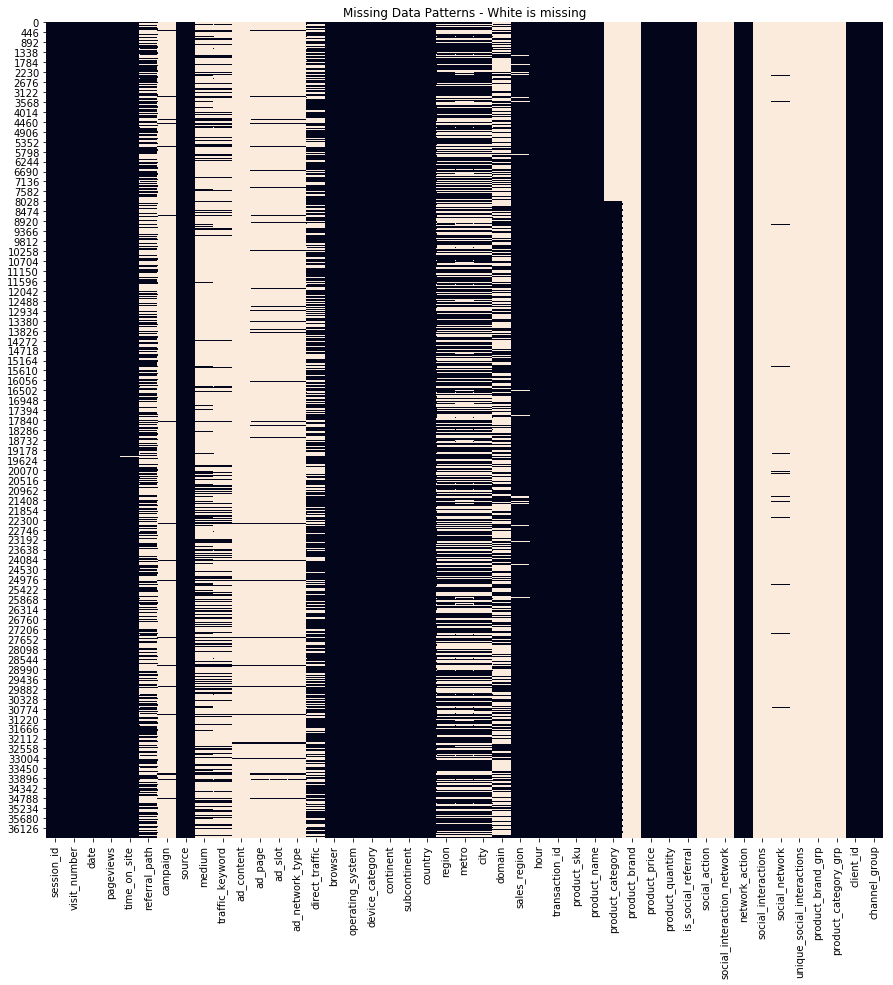

In [49]:
# HANDLE MISSING VALUES
# ---------------------

# Plot missing values patterns
nan_chars = {'nan',
             'None',
             '(none)',
             '(not set)',
             'not available in demo dataset'}
             
nan_mask = (df.isna() 
            | df.isnull() 
            | (df == 'nan')
            | (df == 'None')
            | (df == '(none)') 
            | (df == '(not set)') 
            | (df == 'not available in demo dataset'))
plt.figure(figsize=(15, 15))
ax = sns.heatmap(nan_mask, cbar=False);
plt.title('Missing Data Patterns - White is missing')
plt.show()

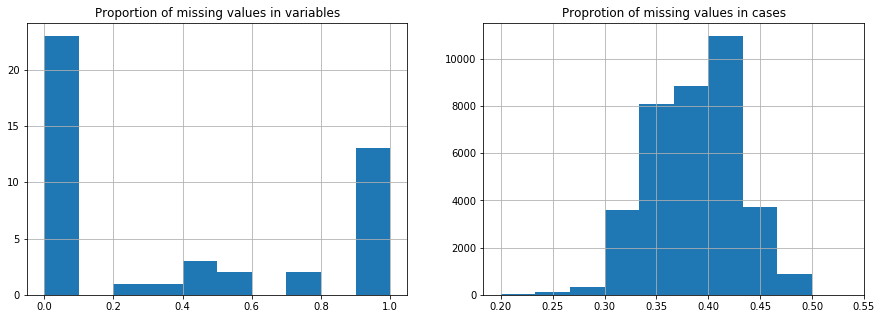

In [50]:
# Plot missing values proportion across variables and cases
nan_prop_vars = ((nan_mask.sum() / nan_mask.index.size)
                 .rename('proprotion of missing values in variables')
                 .sort_values(ascending=False))

nan_prop_cases = ((nan_mask.sum(axis=1) / nan_mask.columns.size)
                 .rename('proprotion of missing values in cases')
                 .sort_values(ascending=False))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
nan_prop_vars.hist(ax=ax1)
ax1.set_title('Proportion of missing values in variables')
nan_prop_cases.hist(ax=ax2)
ax2.set_title('Proprotion of missing values in cases');

In [51]:
# Analyze proportion of missing values and missing vlaue codes in variables
def analyze_nan_levels(var, nan_chars):
    levels = var.unique()
    nan_levels = set(levels) & nan_chars | set(levels[pd.isna(levels)])
    return pd.Series({'num_levels': len(levels),
                      'levels': set(levels),
                      'num_nan_levels': len(nan_levels),
                      'nan_levels': nan_levels})

nan_vars_summary = nan_prop_vars.to_frame('nan_proportion')
nan_vars_summary[['num_levels', 
                  'levels', 
                  'num_nan_levels', 
                  'nan_levels']] = (df.apply(analyze_nan_levels, 
                                             args=(nan_chars,))
                                    .T)

display(nan_vars_summary[nan_prop_vars > 0])

,nan_proportion,num_levels,levels,num_nan_levels,nan_levels
social_interaction_network,1.000000,1,{nan},1,{nan}
social_action,1.000000,1,{nan},1,{nan}
product_category_grp,1.000000,1,{(not set)},1,{(not set)}
product_brand_grp,1.000000,1,{(not set)},1,{(not set)}
unique_social_interactions,1.000000,1,{None},1,{None}
social_interactions,1.000000,1,{None},1,{None}
product_brand,1.000000,1,{(not set)},1,{(not set)}
social_network,0.992040,9,"{Google Groups, YouTube, Facebook, (not set), ...",1,{(not set)}
ad_content,0.987937,13,"{nan, {KeyWord:Google Branded Gear}, {KeyWord:...",1,{nan}
campaign,0.977980,4,"{AW - Dynamic Search Ads Whole Site, (not set)...",1,{(not set)}


In [52]:
# FEATURE ENGINEERING
# -------------------
reload(helper)
re_engineered_vars = ['traffic_keyword',
                      'product_brand',
                      'product_category',
                      'sales_region',
                      'avg_visits',
                      'avg_pageviews',
                      'avg_time_on_site',
                      'social_referral',
                      'ad_campaign',
                      'avg_product_revenue',
                      'avg_unique_products']

# Reconstruct traffic variables
# -----------------------------
df['traffic_keyword'] = (df['traffic_keyword']
                         .astype(object)
                         .apply(helper.reconstruct_traffic_keyword)
                         .astype('category'))

# Engineer brand variable from brand keywords in product name
# and brand variables. Remaining (not set) brand is Google brand
# --------------------------------------------------------------
product_df = helper.query_product_info(client, query_params)
df['product_brand'] = (helper.reconstruct_brand(df['product_sku'], product_df)
                       .astype('category'))

# Engineer category labels from category variables and keywords in product name.
# Remaining (not set) brand is predicted by Naive Bayes Model with 
# f1 weighted test score > 0.8% (0.985)
# ------------------------------------------------------------------------------

# load mappings from category variables to category_label
product_category = (
    pd.read_excel('product_categories.xlsx', 
                  sheet_name='product_category_id')
    [['product_category', 'category_label']]
)

product_category_grp = pd.read_excel('product_categories.xlsx', 
                                        sheet_name='product_category_grp_id')

category_spec = {'product_category': product_category,
                 'product_category_grp': product_category_grp}

# reconstruct category labels from category variables and product names
df['product_category'] = (
    helper.reconstruct_category(df['product_sku'], product_df, category_spec)
    .astype('category')
)

# reconstruct sales region from subcontinent labels
# -------------------------------------------------
df['sales_region'] = (df['subcontinent']
                       .apply(helper.reconstruct_sales_region)
                       .astype('category'))

# cast binary variable is_social_referral
df['social_referral'] = ((df['is_social_referral']
                          .replace(['Yes', 'No'], [True, False]))
                          if df['is_social_referral'].dtype != 'bool'  
                          else df['is_social_referral'])

# create ad campaign flag from campaign and add variables
ad_vars = ['campaign', 'ad_content', 'ad_page', 'ad_slot', 'ad_network_type']
df['ad_campaign'] = False
df.loc[~nan_mask[ad_vars].all(axis=1), 'ad_campaign'] = True

In [53]:
# drop cases and variables with high proportion of missing values
# ---------------------------------------------------------------

# Variables with high proportion of missing values
drop_vars = [
    'referral_path',                 # not valuable information
#     'product_name',                  # too detailed, category sufficient
    'product_brand',                 # reconstructed
    'product_brand_grp',             # reconstructed
    'product_category_grp',          # reconstructed
    'is_social_referral',            # reconstructed social_referral
    'traffic_kbeyword',               # to detailed and collinear with channel group
    'campaign',                      # reconstructed is_ad_campaign
    'ad_content',                    # reconstructed is_ad_campaign
    'ad_page',                       # reconstructed is_ad_campaign
    'ad_slot',                       # reconstructed is_ad_campaign
    'ad_network_type',               # reconstructed is_ad_campaign
    'domain',                        # high proportion of missing values
    'city',                          # high proportion of missing values
    'region',                        # high proportion of missing values
    'metro',                         # high proportion of missing values
    'direct_traffic',                # collinear with medium & channel group
    'medium',                        # collinear with channel group
    'social_action',                 # no valid values
    'social_interaction_network',    # no valide values
    'network_action',                # not valuable information
    'social_interactions',           # no valide values
    'unique_social_interactions'     # no valide values
    
]

# cases
cases = (nan_mask[['continent', 
                   'subcontinent', 
                   'country',
                   'time_on_site']]
         .any(axis=1))

# delete variables and cases
clean_df = (df.drop(columns=drop_vars, errors='ignore')
              .drop(index=df.index[cases], errors='ignore'))

# check for missing values
clean_mask = (clean_df.isna() 
                | clean_df.isnull() 
                | (clean_df == 'nan')
                | (clean_df == 'None')
                | (clean_df == '(none)') 
                | (clean_df == '(not set)') 
                | (clean_df == 'not available in demo dataset'))

# encode and aggregate engineered variables on customer level
# -----------------------------------------------------------
agg_df = helper.aggregate_data(clean_df)

# dipslay summary
txt = 'MISSING VALUE AND RE-EGINEERING SUMMARY'
print(txt + '\n' + '-'*len(txt) + '\n' )
txt = ('Missing values: {} ({:.1f}%)'
       .format(nan_mask.sum().sum(),
               nan_mask.sum().sum() / np.product(nan_mask.shape) * 100))       
print(txt + '\n')

txt = ('Re-engineered variables: {} ({:.1f}%)'
       .format(len(re_engineered_vars), 
               len(re_engineered_vars) / df.columns.size * 100))   
print(txt)
print(re_engineered_vars, '\n')

txt = ('Deleteted variables: {} ({:.1f}%)'
       .format(len(drop_vars), 
               len(drop_vars) / df.columns.size * 100))       
print(txt)
print(drop_vars, '\n')

txt = ('Deleteted cases: {} ({:.1f}%)'
       .format(cases.sum(), cases.sum() / df.index.size * 100))       
print(txt)
display(df[cases])

txt = ('\nMissing values: {} ({:.1f}%)'
       .format(clean_df.isna().sum().sum(),
               clean_df.isna().sum().sum() / np.prod(clean_df.shape)))       
print(txt + '\n')

txt = ('ENCODED AND AGGREGATED DATA ON CLIENT LEVEL:')
print(txt, '\n' + '-' * len(txt))
display(agg_df)

MISSING VALUE AND RE-EGINEERING SUMMARY
---------------------------------------

Missing values: 634464 (38.6%)

Re-engineered variables: 11 (23.4%)
['traffic_keyword', 'product_brand', 'product_category', 'sales_region', 'avg_visits', 'avg_pageviews', 'avg_time_on_site', 'social_referral', 'ad_campaign', 'avg_product_revenue', 'avg_unique_products'] 

Deleteted variables: 22 (46.8%)
['referral_path', 'product_brand', 'product_brand_grp', 'product_category_grp', 'is_social_referral', 'traffic_kbeyword', 'campaign', 'ad_content', 'ad_page', 'ad_slot', 'ad_network_type', 'domain', 'city', 'region', 'metro', 'direct_traffic', 'medium', 'social_action', 'social_interaction_network', 'network_action', 'social_interactions', 'unique_social_interactions'] 

Deleteted cases: 20 (0.1%)


,session_id,visit_number,date,pageviews,time_on_site,referral_path,campaign,source,medium,traffic_keyword,...,network_action,social_interactions,social_network,unique_social_interactions,product_brand_grp,product_category_grp,client_id,channel_group,social_referral,ad_campaign
2285,35148085511804167821471571392,1,2016-08-18,53,3696.0,NaN,(not set),google,organic,(not provided),...,:,None,(not set),None,(not set),(not set),3514808551180416782,Organic Search,False,False
2286,35148085511804167821471571392,1,2016-08-18,53,3696.0,NaN,(not set),google,organic,(not provided),...,:,None,(not set),None,(not set),(not set),3514808551180416782,Organic Search,False,False
2287,35148085511804167821471571392,1,2016-08-18,53,3696.0,NaN,(not set),google,organic,(not provided),...,:,None,(not set),None,(not set),(not set),3514808551180416782,Organic Search,False,False
2395,35148085511804167821471628052,2,2016-08-19,44,888.0,NaN,(not set),google,organic,(not provided),...,:,None,(not set),None,(not set),(not set),3514808551180416782,Organic Search,False,False
2396,35148085511804167821471628052,2,2016-08-19,44,888.0,NaN,(not set),google,organic,(not provided),...,:,None,(not set),None,(not set),(not set),3514808551180416782,Organic Search,False,False
2397,35148085511804167821471628052,2,2016-08-19,44,888.0,NaN,(not set),google,organic,(not provided),...,:,None,(not set),None,(not set),(not set),3514808551180416782,Organic Search,False,False
3058,89193366187542561691472076890,2,2016-08-24,11,384.0,NaN,(not set),(direct),(none),(not applicable),...,:,None,(not set),None,(not set),(not set),8919336618754256169,Direct,False,False
3178,30330275787927026921472185074,3,2016-08-25,12,688.0,NaN,(not set),(direct),(none),(not applicable),...,:,None,(not set),None,(not set),(not set),3033027578792702692,Direct,False,False
4882,82898231057682615981473402660,6,2016-09-09,2,NaN,NaN,AW - Dynamic Search Ads Whole Site,google,cpc,(not relevant),...,:,None,(not set),None,(not set),(not set),8289823105768261598,Paid Search,False,True
4883,82898231057682615981473402660,6,2016-09-09,2,NaN,NaN,AW - Dynamic Search Ads Whole Site,google,cpc,(not relevant),...,:,None,(not set),None,(not set),(not set),8289823105768261598,Paid Search,False,True



Missing values: 0 (0.0%)

ENCODED AND AGGREGATED DATA ON CLIENT LEVEL: 
--------------------------------------------


,avg_visits,avg_pageviews,avg_time_on_site,social_referral,ad_campaign,source*(direct),source*Partners,source*ask,source*basecamp.com,source*bing,...,hour*14,hour*15,hour*16,hour*17,hour*18,hour*19,hour*20,hour*21,hour*22,hour*23
client_id,,,,,,,,,,,,,,,,,,,,,
0000213131142648941,1.0,13.0,272.0,0.0,0.0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
0002871498069867123,5.0,22.0,1849.0,0.0,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0003450834640354121,8.0,66.0,2434.0,0.0,0.0,0,0,0,0,0,...,5,0,0,0,0,0,0,0,0,0
0003961110741104601,2.0,20.0,502.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
000435324061339869,2.0,11.0,627.0,0.0,0.0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991633376050115277,1.0,16.0,386.0,1.0,0.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9994767073213036303,6.0,30.0,755.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997409246962677759,2.0,65.0,1423.0,0.0,0.0,1,0,0,0,0,...,0,0,0,0,5,0,0,0,0,0


In [55]:
# BUILD MACHINE LEARNING MODEL TO PREDICT BUYER PERSONA
# ------------------------------------------------------

# Add buyer personas (customer clusters) to additional data
data = pd.merge(agg_df, 
                y_pred,
                how='left',
                left_index=True,
                right_index=True)

# Split data
X = data[data.columns[~data.columns.str.contains('clusters')]]
Y = data[data.columns[data.columns.str.contains('clusters')]]
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=random_state
)

# Screen Classifiers
# ------------------

# Cycle over cluster solutions
pipe, grid_search = {}, {}
for k in num_seeds:
    # set pipeline
    pipe_steps = [
        ('preprocessor', StandardScaler()),
        ('feature_selector', 
         SelectFromModel(
             RandomForestClassifier(
                 n_jobs=-1, 
                 random_state=random_state
            ),
            threshold = -np.inf
         )
        ),
        ('classifier', None)
    ]
    
    pipe[k] = Pipeline(pipe_steps)

    # set grid_search
    param_grid = {
        'feature_selector__max_features': [8, 20],
        'classifier': [
            RandomForestClassifier(n_jobs=-1, random_state=random_state),
            ExtraTreesClassifier(n_jobs=-1, random_state=random_state),
            AdaBoostClassifier(random_state=random_state),
            GradientBoostingClassifier(random_state=random_state),
            LinearSVC(dual=False, random_state=random_state),
            SVC(random_state=random_state),
            DummyClassifier(random_state=random_state)
        ]
    }
    
    grid_search[k] = GridSearchCV(
        estimator=pipe[k], 
        param_grid=param_grid, 
        scoring='f1_weighted',
        n_jobs=-1,
        return_train_score=True
    )

    # run screening
    title = 'MODEL SCREENING EVALUATION: {} CLUSTERS'.format(k)
    grid_search[k] = helper.screen_model(
        X_train, 
        X_test, 
        Y_train['clusters_{}'.format(k)], 
        Y_test['clusters_{}'.format(k)],
        grid_search=grid_search[k],
        title=title,
        verbose='text'
    )

MODEL SCREENING EVALUATION: 3 CLUSTERS
--------------------------------------


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,overfitting,param_classifier,param_feature_selector__max_features,std_test_score,std_train_score
7,3.718546,0.208679,0.678503,0.738026,0.059524,GradientBoostingClassifier,20,0.001379,0.001971
9,1.189401,0.227680,0.658126,0.666519,0.008393,LinearSVC,20,0.004100,0.001685
11,3.835886,0.948388,0.657878,0.681800,0.023922,SVC,20,0.010748,0.001747
1,1.128065,0.257348,0.640847,0.982193,0.341345,RandomForestClassifier,20,0.005643,0.000402
5,1.262406,0.193011,0.632816,0.651247,0.018431,AdaBoostClassifier,20,0.014651,0.006123
6,2.804160,0.198678,0.632116,0.703765,0.071650,GradientBoostingClassifier,8,0.016087,0.009373
3,1.129398,0.239347,0.626924,1.000000,0.373076,ExtraTreesClassifier,20,0.009802,0.000000
10,2.912833,0.638370,0.599586,0.621976,0.022389,SVC,8,0.014494,0.012336
8,0.836381,0.146008,0.597437,0.599323,0.001886,LinearSVC,8,0.006528,0.008967
4,1.233737,0.184344,0.595794,0.605935,0.010141,AdaBoostClassifier,8,0.018647,0.019599


Best model is GradientBoostingClassifier with F1 test weighted score 0.704

MODEL SCREENING EVALUATION: 6 CLUSTERS
--------------------------------------


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,overfitting,param_classifier,param_feature_selector__max_features,std_test_score,std_train_score
7,9.109521,0.241680,0.593952,0.710331,0.116380,GradientBoostingClassifier,20,0.006136,0.003589
11,3.601539,1.160400,0.554628,0.613939,0.059310,SVC,20,0.001648,0.004438
6,6.642047,0.288016,0.548085,0.665289,0.117204,GradientBoostingClassifier,8,0.007956,0.007508
1,1.302074,0.244347,0.545530,0.986290,0.440760,RandomForestClassifier,20,0.003125,0.000801
3,1.209736,0.238347,0.528610,1.000000,0.471390,ExtraTreesClassifier,20,0.009900,0.000000
9,1.229070,0.212346,0.513875,0.529161,0.015285,LinearSVC,20,0.003274,0.001336
10,2.926834,0.689039,0.510265,0.545166,0.034900,SVC,8,0.009779,0.003713
0,1.253072,0.239680,0.503262,0.982197,0.478935,RandomForestClassifier,8,0.006488,0.000093
2,1.296074,0.250681,0.494633,1.000000,0.505367,ExtraTreesClassifier,8,0.010780,0.000000
8,0.891384,0.177343,0.464534,0.471687,0.007153,LinearSVC,8,0.005626,0.004435


Best model is GradientBoostingClassifier with F1 test weighted score 0.601



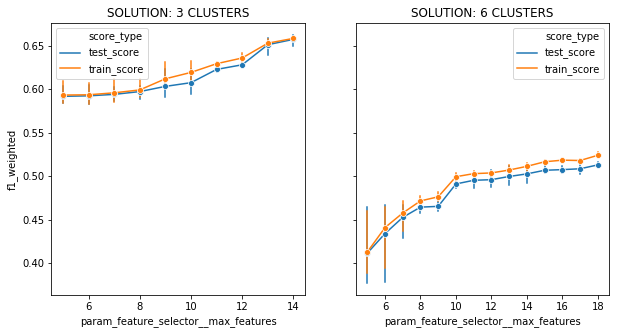

In [58]:
# fine tune selected classifiers
# ------------------------------
reload(helper)
# Cycle over cluster solutions
pipe, grid_search = {}, {}
max_features = [
    np.arange(5, 15, 1),
    np.arange(5, 19, 1)
]
fig, axes = plt.subplots(
    1, len(num_seeds), figsize=(10, 5), sharey=True
)
for i, (ax, k, num_features) in enumerate(zip(
    axes.flatten(), num_seeds, max_features)):
    
    # set pipeline
    pipe_steps = [
        ('preprocessor', StandardScaler()),
        ('feature_selector',
         SelectFromModel(
             RandomForestClassifier(
                 n_jobs=-1, 
                 random_state=random_state
            ),
            threshold = -np.inf
         )
        ),
        ('classifier', None)
    ]
    
    pipe[k] = Pipeline(pipe_steps)

    # set grid_search
    param_grid = {
        'feature_selector__max_features': num_features,
        'classifier': [
            LinearSVC(random_state=random_state, dual=False)
        ]
    }
    
    grid_search[k] = GridSearchCV(
        estimator=pipe[k], 
        param_grid=param_grid, 
        scoring='f1_weighted',
        n_jobs=-1,
        return_train_score=True
    )

    # run screening
    title = 'SOLUTION: {} CLUSTERS'.format(k)
    plt.sca(ax)
    grid_search[k] = helper.screen_model(
        X_train, 
        X_test, 
        Y_train['clusters_{}'.format(k)], 
        Y_test['clusters_{}'.format(k)],
        grid_search=grid_search[k],
        fine_param='param_feature_selector__max_features',
        title=title,
        verbose='plot'
    )

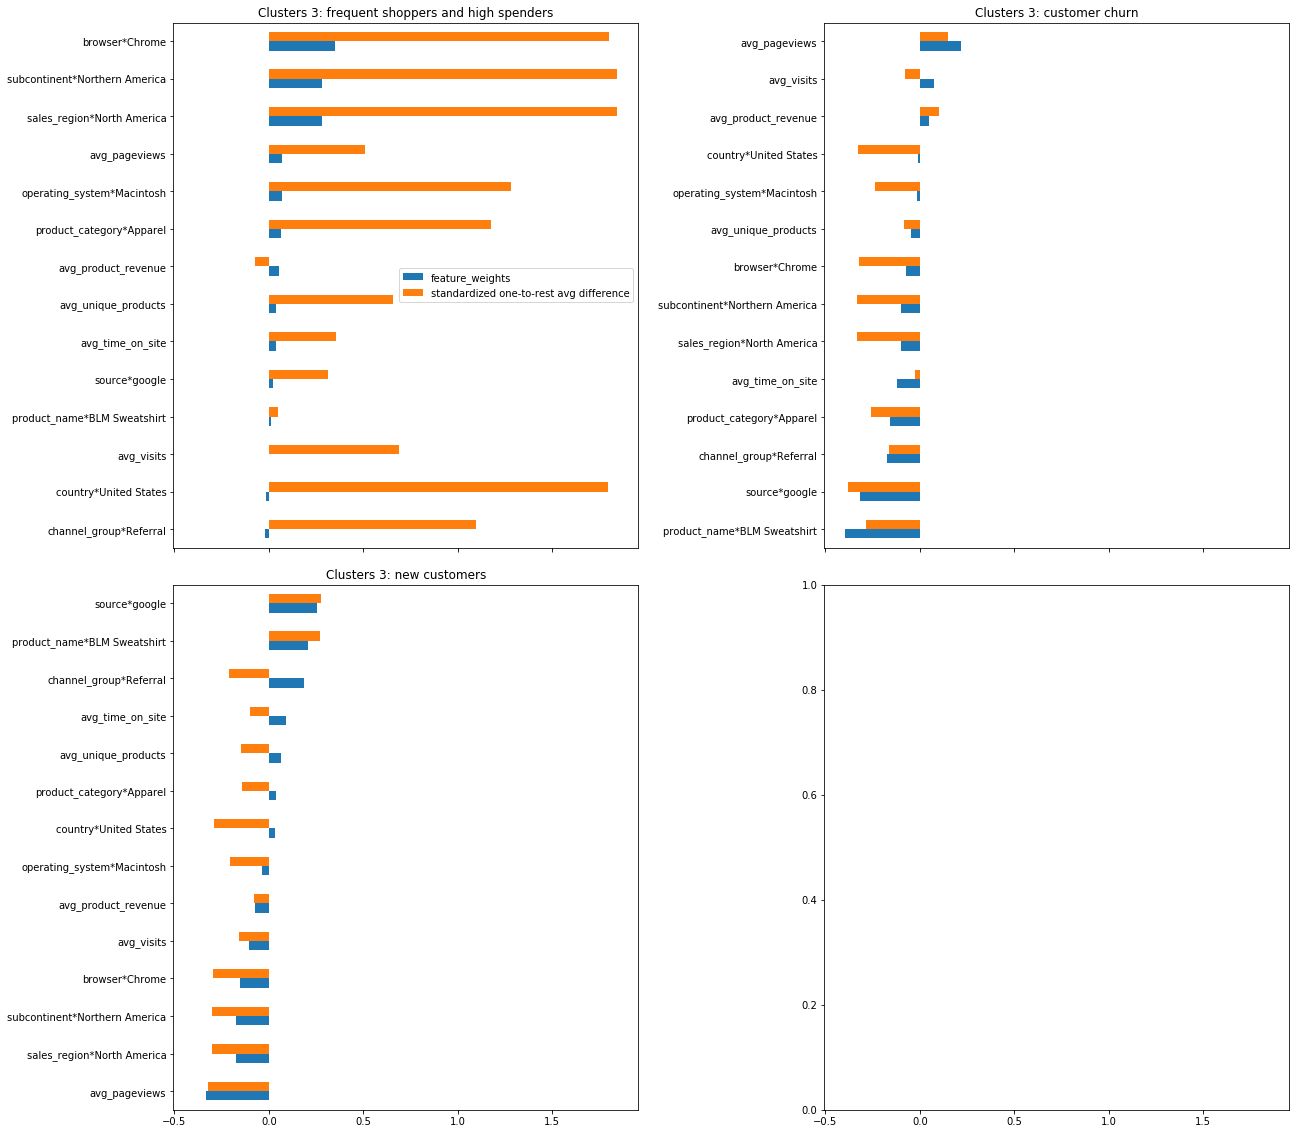

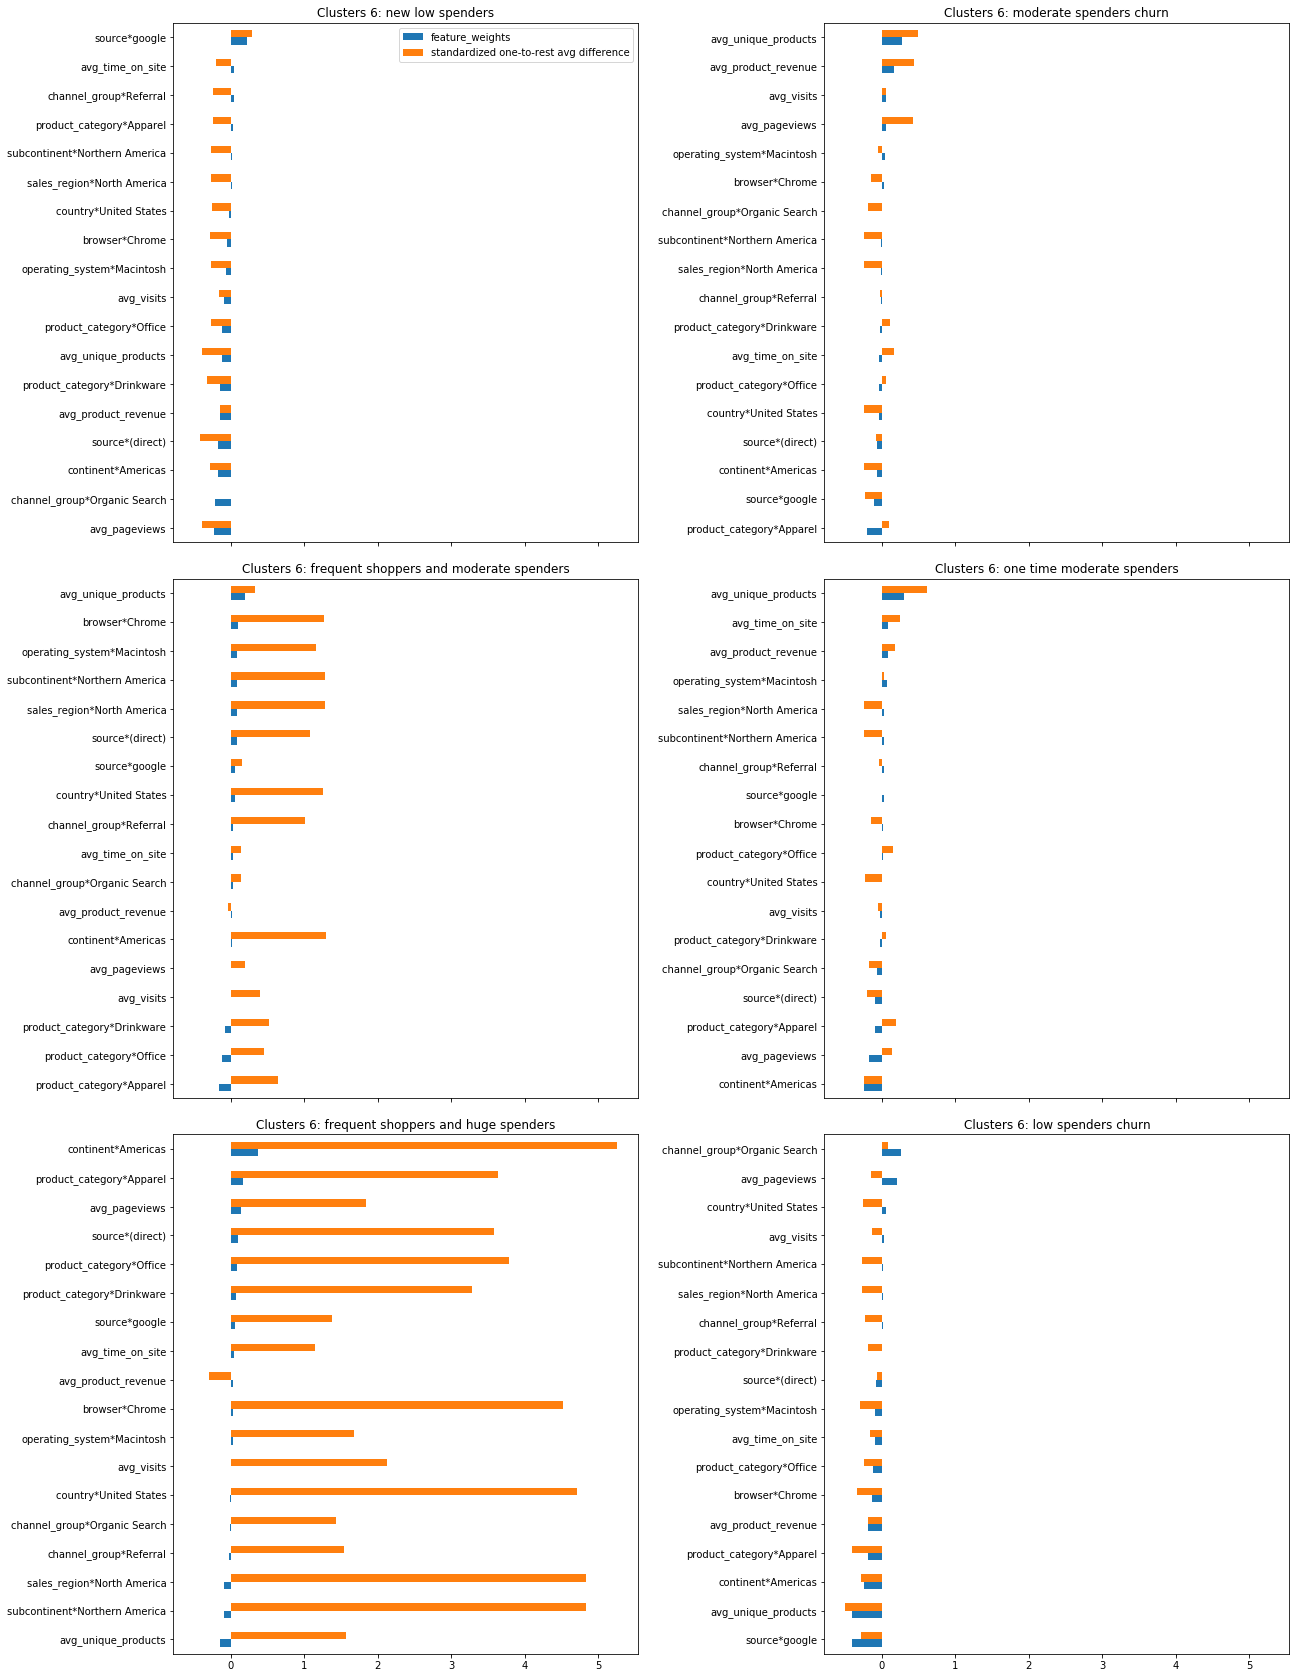

In [59]:
# PROFILING BUYER PERSONA
# -----------------------
reload(helper)
X_std = pd.DataFrame(StandardScaler().fit_transform(X),
                     index=X.index, columns=X.columns)
for k in num_seeds:
    feature_names = X.columns[grid_search[k]
                              .best_estimator_
                              .named_steps
                              .feature_selector
                              .get_support()]
    
    title = 'Clusters {}:'.format(k)
    helper.plot_features_significance(
        grid_search[k].best_estimator_['classifier'], 
        X_std,
        Y['clusters_{}'.format(k)],
        feature_names, 
        cluster_names[k], 
        title=title,
        threshold=-np.inf)

## 6. Deployment